In [484]:
# Imports
import os
import re
import unicodedata
from datetime import datetime
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import json

from ahocorasick import Automaton
from scipy.stats import zscore
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Settings
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.options.display.max_rows = 4000


# Importing all relevant dataframes

In [485]:
# Importing previously used dataframes, relevant to the analysis
df = pd.read_csv('Data/Working Dataframes/df.csv')
scraped_df = pd.read_csv('Data/Working Dataframes/scraped_df.csv')
descriptive_df = pd.read_csv('Data/Working Dataframes/descriptive_df.csv')
keyword_position = pd.read_csv('Data/Working Dataframes/keyword_position.csv')
keyword_position_long = pd.read_csv('Data/Working Dataframes/keyword_position_long.csv')

In [486]:
scraped_df.head()

,Unnamed: 0.1,ID,company,Founded Date,website,Headquarters Location,Industry Groups,Industries,CB Rank (Company),Full Description,...,Founded Year,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022,Last Funding Type ORD,Series_A_bin,Number of Employees ORD,z_score
0,2,17422,PromptLayer,2021-08-01,https://www.promptlayer.com,"New York, New York, United States",Software,Software,130969.0,NaN,...,2021,False,False,False,True,False,1.0,False,1.0,-0.085751
1,3,82006,American Safety,2019-01-01,https://american-safetyllc.com,"Belle Chasse, Louisiana, United States","Commerce and Shopping, Education, Manufacturing","Industrial, Rental, Training",2051287.0,NaN,...,2019,False,True,False,False,False,0.0,False,3.0,-0.085751
2,4,58824,Nerdee's,2020-01-01,https://www.nerdees.com,"Walnut, California, United States","Clothing and Apparel, Commerce and Shopping, C...","Apparel, E-Commerce, Fashion, Shoes",1038376.0,"Nerdee's a seller of clothing, accessories, ga...",...,2020,False,False,True,False,False,0.0,False,2.0,-0.085751
3,6,58333,Ziegel,2018-07-06,https://www.ziegel.es,"Playa Del Rey, California, United States",Real Estate,Real Estate,987441.0,"We offer support, infrastructures and conditio...",...,2018,True,False,False,False,False,0.0,False,3.0,-0.085751
4,10,25169,Lodestar,2019-08-01,https://www.lodestar.ai,"San Jose, California, United States","Artificial Intelligence (AI), Data and Analyti...","Artificial Intelligence (AI), Computer Vision,...",216067.0,With Lodestar you can annotate video far faste...,...,2019,False,True,False,False,False,0.0,False,2.0,-0.085751


In [487]:
scraped_df.head()

,Unnamed: 0.1,ID,company,Founded Date,website,Headquarters Location,Industry Groups,Industries,CB Rank (Company),Full Description,...,Founded Year,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022,Last Funding Type ORD,Series_A_bin,Number of Employees ORD,z_score
0,2,17422,PromptLayer,2021-08-01,https://www.promptlayer.com,"New York, New York, United States",Software,Software,130969.0,NaN,...,2021,False,False,False,True,False,1.0,False,1.0,-0.085751
1,3,82006,American Safety,2019-01-01,https://american-safetyllc.com,"Belle Chasse, Louisiana, United States","Commerce and Shopping, Education, Manufacturing","Industrial, Rental, Training",2051287.0,NaN,...,2019,False,True,False,False,False,0.0,False,3.0,-0.085751
2,4,58824,Nerdee's,2020-01-01,https://www.nerdees.com,"Walnut, California, United States","Clothing and Apparel, Commerce and Shopping, C...","Apparel, E-Commerce, Fashion, Shoes",1038376.0,"Nerdee's a seller of clothing, accessories, ga...",...,2020,False,False,True,False,False,0.0,False,2.0,-0.085751
3,6,58333,Ziegel,2018-07-06,https://www.ziegel.es,"Playa Del Rey, California, United States",Real Estate,Real Estate,987441.0,"We offer support, infrastructures and conditio...",...,2018,True,False,False,False,False,0.0,False,3.0,-0.085751
4,10,25169,Lodestar,2019-08-01,https://www.lodestar.ai,"San Jose, California, United States","Artificial Intelligence (AI), Data and Analyti...","Artificial Intelligence (AI), Computer Vision,...",216067.0,With Lodestar you can annotate video far faste...,...,2019,False,True,False,False,False,0.0,False,2.0,-0.085751


In [488]:
scraped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8367 entries, 0 to 8366
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0.1                            8367 non-null   int64  
 1   ID                                      8367 non-null   int64  
 2   company                                 8367 non-null   object 
 3   Founded Date                            8367 non-null   object 
 4   website                                 8367 non-null   object 
 5   Headquarters Location                   8367 non-null   object 
 6   Industry Groups                         8367 non-null   object 
 7   Industries                              8367 non-null   object 
 8   CB Rank (Company)                       8367 non-null   float64
 9   Full Description                        5161 non-null   object 
 10  Number of Employees                     8367 non-null   obje

# Feature Engineering
First I remove all columns that are not relevant to the analyses.

In [489]:
# Deleting unneeded Columns
scraped_df.drop(columns = ['ID', 'CB Rank (Company)', 'Number of Employees.1', 'IPO Status', 'IPO Date', 'Valuation at IPO Currency (in USD)', 'IPqwery - Patents Granted',
                            'NA Count', 'org_uuid',  'Unnamed: 0', 'Founded Year' ], inplace = True)

First, I selected only the startups that got at most 1 round of funding. That way, I can exclude previous funding as a strong signal that would otherwise skew my results. Additionally, I filter out startups that are likely data errors. 

In [490]:
# Formatting features to their correct format
scraped_df['Founded Date'] = pd.to_datetime(scraped_df['Founded Date'])
scraped_df['Last Funding Date'] = pd.to_datetime(scraped_df['Last Funding Date'])

# Removing outliers based on the z-scores of total funding amount
print(f"Number of startups before outlier cleaning {len(scraped_df)}")
scraped_df['z_score_count'] = zscore(scraped_df['Total Funding Amount Currency (in USD)'])
scraped_df = scraped_df[scraped_df['z_score_count'] < 4]
scraped_df = scraped_df[scraped_df['z_score_count'] > -4]
print(f"Number of startups remaining after outlier cleaning {len(scraped_df)}")


# Filtering rows with up to one funding round
scraped_df = scraped_df[scraped_df['Number of Funding Rounds'] < 2]

print(f"Number of startups remaining: {len(scraped_df)}")

Number of startups before outlier cleaning 8367
Number of startups remaining after outlier cleaning 8335
Number of startups remaining: 7953


Next, I scale the categorical feature number of employees to ordinal.

In [491]:
# Defining the mapping of categorical features
ordinal_map = {
    '1-10': 1,
    '11-50': 2,
    '51-100': 3,
    '101-250': 4,
    '251-500': 5,
    '501-1000': 6,
    '1001-5000': 7,
    '5001 - 10000': 9,
    '10001+': 8
}

# Applying the mapping to Number of Employees
scraped_df['Number of Employees ORD'] = scraped_df['Number of Employees'].map(ordinal_map)

# Initializing of Analysis Functions
In a next step, I set up various functions to efficiently analyse different features of the dataset.

## Logistic Regression

In [492]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

In [493]:
def LogReg_train_and_eval(data, data_name, features, target):
    """
    Trains and evaluates a logistic regression model on specified features and a target variable.
    
    Parameters:
    - data: dataframe containing the dataset.
    - features: List of column names to be used as features.
    - target: Column name to be used as the target variable.
    
    Returns:
    - accuracy: Accuracy of the model.
    - logloss: Logarithmic Loss of the model.
    - auc: Area Under the ROC Curve.
    - coefficients: Coefficients of the model corresponding to each feature.
    """
    
    # Selecting features and target variables
    X = data[features]
    y = data[target]
    
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Defining the Logistic Regression model
    model = LogisticRegression()
    
    # Training the model on the training data
    model.fit(X_train, y_train)
    
    # Making predictions on the testing data
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the class 1
    
    # Calculating evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Getting the model coefficients for each feature
    coefficients = model.coef_[0]
    
    # Printing results
    print(f'Logistic Regression results for {data_name}:')
    print(f"Accuracy: {accuracy}, Log Loss: {logloss}, AUC: {auc}, Coefficients: {coefficients}")
    return 


In [494]:
def RareEventsLogReg_train_and_eval(data, data_name, features, target):
    """
    Trains and evaluates a penalized logistic regression model on specified features and a target variable,
    specially handling rare event cases in the dataset.

    Parameters:
    - data: dataframe containing the dataset.
    - data_name: A name or description for the dataset (used in reporting results).
    - features: List of column names to be used as features.
    - target: Column name to be used as the target variable.
    
    Returns:
    - accuracy: Accuracy of the model.
    - logloss: Logarithmic Loss of the model.
    - auc: Area Under the ROC Curve.
    - coefficients: Coefficients of the model corresponding to each feature.
    """

    # Selecting features and target variables
    X = data[features]
    y = data[target]
    
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Defining the penalized Logistic Regression model
    # Selecting a 'l2' penalty to help with rare events, as can be found in the dataframe
    model = LogisticRegression(class_weight='balanced', penalty='l2', solver='saga', max_iter=1000)
    
    # Training the model on the training data
    model.fit(X_train, y_train)
    
    # Making predictions on the testing data
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    
    # Calculating evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Getting the model coefficients for each feature
    coefficients = model.coef_[0]
    
    # Printing results
    print(f'Rare Events Logistic Regression results for {data_name}:')
    print(f"Accuracy: {accuracy}, Log Loss: {logloss}, AUC: {auc}")
    print("Coefficients:", dict(zip(features, coefficients)))

    return accuracy, logloss, auc, dict(zip(features, coefficients))



## Linear Regression 

In [495]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [496]:
def lin_reg_train_and_eval(data, data_name, features, target):
    """
    Trains and evaluates a linear regression model on specified features and a target variable.
    
    Parameters:
    - data: dataframe containing the dataset.
    - data_name: Name of the dataframe (for printing purposes).
    - features: List of column names to be used as features.
    - target: Column name to be used as the target variable.
    
    Outputs:
    Prints the R-squared value, RMSE, and model coefficients.
    """

    # Selecting features and target variables
    X = data[features]
    y = data[target]
    
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Defining the Linear Regression model
    model = LinearRegression()
    
    # Training the model on the training data
    model.fit(X_train, y_train)
    
    # Making predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculating evaluation metrics
    r_squared = r2_score(y_test, y_pred)  # R-squared value
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Root Mean Squared Error
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    # Getting the model coefficients for each feature
    coefficients = model.coef_
    
    # Printing results
    print(f'Linear Regression results for {data_name}:')
    print(f"R-squared: {r_squared:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    print("Coefficients:")
    for feature, coef in zip(features, coefficients):
        print(f"  {feature}: {coef:.4f}")
    return 


## XGBoost

In [497]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, mean_absolute_percentage_error

In [498]:
def xgb_train_and_eval(data, data_name, features, target, model_type='classification', reg_alpha=0.1):
    """
    Trains and evaluates an XGBoost model on specified features and a target variable,
    with an option for L1 regularization (LASSO).
    
    Parameters:
    - data: dataframe containing the dataset.
    - data_name: Name of the dataframe (for printing purposes).
    - features: List of column names to be used as features.
    - target: Column name to be used as the target variable.
    - model_type: Type of model to train ('classification' or 'regression').
    - reg_alpha: float, default 0.1. L1 regularization term on weights (LASSO).
    
    Outputs:
    Prints model evaluation metrics based on the model type.
    """
    
    # Selecting features and target variables
    X = data[features]
    y = data[target]
    
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Defining the XGBoost model with L1 regularization
    if model_type == 'classification':
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', alpha=reg_alpha)
    elif model_type == 'regression':
        model = xgb.XGBRegressor(alpha=reg_alpha)
    else:
        raise ValueError("model_type must be either 'classification' or 'regression'")
    
    # Training the model on the training data
    model.fit(X_train, y_train)
    
    # Making predictions on the test set
    y_pred = model.predict(X_test)

    # Splitting the prediction and metric calculation for each model type
    if model_type == 'classification':

        # Calculating classification metrics
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        print(f'XGBoost Classification results for {data_name}:')
        print(f"Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

    elif model_type == 'regression':

        # Calculating regression metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        print(f'XGBoost Regression results for {data_name}:')
        print(f"RMSE: {rmse:.4f}")
        print(f'MAPE: {mape:.4f}')
    
    # Calculating the feature importance
    print("Feature Importances:")
    for feature, importance in zip(features, model.feature_importances_):
        print(f"  {feature}: {importance:.4f}")
    return

## Random Forest

In [499]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, mean_absolute_percentage_error

In [500]:
def rf_train_and_eval(data, data_name, features, target, model_type='classification', tune_params=False):
    """
    Trains and evaluates a Random Forest model on specified features and a target variable,
    with optional hyperparameter tuning.

    Parameters:
    - data: DataFrame containing the dataset.
    - data_name: Name of the DataFrame (for printing purposes).
    - features: List of column names to be used as features.
    - target: Column name to be used as the target variable.
    - model_type: Type of model to train ('classification' or 'regression').
    - tune_params: Boolean to activate hyperparameter tuning.
    """
    
    # Selecting features and target variables
    X = data[features]
    y = data[target]
    
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Implementing a switch between regression and classification to make the function applicable more broadly
    if model_type == 'classification':
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    elif model_type == 'regression':
        model = RandomForestRegressor(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_leaf': [1, 2, 4]
        }
    else:
        raise ValueError("model_type must be either 'classification' or 'regression'")

    # Implementing tunable hyperparameters
    if tune_params:
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy' if model_type == 'classification' else 'neg_mean_squared_error', verbose=2, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        model = grid_search.best_estimator_
        print("Best parameters found:", grid_search.best_params_)
    
    # Training the model with the training data
    model.fit(X_train, y_train)
    
    # Making predictions on the test set
    y_pred = model.predict(X_test)
    
    # Splitting the calculation of regression metrics 
    if model_type == 'classification':
        accuracy = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)
        print(f'Random Forest Classification results for {data_name}:')
        print(f"Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    elif model_type == 'regression':
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)
        print(f'Random Forest Regression results for {data_name}:')
        print(f"RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    
    # Calculating features importance
    print("Feature Importances:")
    for feature, importance in zip(features, model.feature_importances_):
        print(f"  {feature}: {importance:.4f}")
    return


## Mann-Whitney-U Test


In [501]:
from scipy.stats import mannwhitneyu

In [502]:
def analyze_by_keyword_bin(data, kpi):
    """
    Performs visual analysis and statistical testing on specified numerical KPI against keyword_bin.

    Parameters:
    - data: DataFrame containing the data.
    - kpi: String, the name of the column to analyze.
    
    Outputs:
    - Boxplot for visual comparison.
    - Results of the Mann-Whitney U test.
    """

    # Analysisng data visually with box plots
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(x='keyword_bin', y=kpi, data=data)

    plt.yscale('log')
    plt.title(f'Funding Amount by Keyword Bin for {kpi}')
    plt.ylabel(kpi)
    plt.xlabel('Keyword Bin (0 or 1)')
    plt.show()

    # Analysing data statistically with Mann-Whitney-U test
    group0 = data[data['keyword_bin'] == 0][kpi]
    group1 = data[data['keyword_bin'] == 1][kpi]
    stat, p = mannwhitneyu(group0, group1)
                           
    print(f'Mann-Whitney U Test statistics={stat:.3f}, p={p:.3f}')
    
    # Interpreting p-value
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')


I also set up a more flexible version of the Mann-Whitney-U Test, to improve my analysis.

In [503]:
def analyze_by_feature(data, kpi, group_feature):
    """
    Performs visual analysis and statistical testing on specified KPI against a specified grouping feature.

    Parameters:
    - data: DataFrame containing the data.
    - kpi: String, the name of the column to analyze.
    - group_feature: String, the name of the column to group data by.
    
    Outputs:
    - Boxplot for visual comparison.
    - Results of the Mann-Whitney U test.
    """
    # Analysisng data visually with box plots
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=group_feature, y=kpi, data=data)

    plt.title(f'{kpi} by {group_feature}')
    plt.ylabel(kpi)
    plt.xlabel(group_feature)
    

    # Analysing data statistically with Mann-Whitney-U test
    unique_groups = data[group_feature].unique()
    if len(unique_groups) != 2:
        raise ValueError("Group feature must have exactly two unique values for Mann-Whitney U test.")
    
    group0 = data[data[group_feature] == unique_groups[0]][kpi]
    group1 = data[data[group_feature] == unique_groups[1]][kpi]
    stat, p = mannwhitneyu(group0, group1)

    print(f'Mann-Whitney U Test statistics={stat:.3f}, p={p:.3f}')
    
    # Interpreting p-value
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')


In [504]:
def analyze_by_feature_no_graph(data, kpi, group_feature):
    """
    Performs visual analysis and statistical testing on specified KPI against a specified grouping feature.

    Parameters:
    - data: DataFrame containing the data.
    - kpi: String, the name of the column to analyze.
    - group_feature: String, the name of the column to group data by.
    
    Outputs:
    - Boxplot for visual comparison.
    - Results of the Mann-Whitney U test.
    """
    
    # Analysing data statistically with Mann-Whitney-U test
    unique_groups = data[group_feature].unique()
    if len(unique_groups) != 2:
        raise ValueError("Group feature must have exactly two unique values for Mann-Whitney U test.")
    
    group0 = data[data[group_feature] == unique_groups[0]][kpi]
    group1 = data[data[group_feature] == unique_groups[1]][kpi]
    stat, p = mannwhitneyu(group0, group1)
    
    print(f'Mann-Whitney U Test statistics={stat:.3f}, p={p:.3f}')
    
    # Interpreting p-value
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

## Chi-Square Test


In [505]:
from scipy.stats import chi2_contingency

In [506]:
def chi_square_test(data, column1, column2):
    """
    Performs a Chi-Square Test of Independence to determine if there is a significant
    relationship between two categorical variables.

    Parameters:
    - data: DataFrame containing the dataset.
    - column1: String, the name of the first categorical column.
    - column2: String, the name of the second categorical column.

    Returns:
    - A dictionary containing the chi-square statistic, p-value, degrees of freedom,
      and the expected frequencies.
    """

    # Creating a contingency table
    contingency_table = pd.crosstab(data[column1], data[column2])

    # Performing the Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Printing the results
    print(f"Chi-square Statistic: {chi2:.4f}")
    print(f"P-value: {p:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected Frequencies:")
    print(expected)

    # Returning results in a dictionary to activate for further use if needed
    results = {
        'chi_square_statistic': chi2,
        'p_value': p,
        'degrees_of_freedom': dof,
        'expected_frequencies': expected
    }
    return 

## Comparative Analysis (Averages)

In [507]:
def calculate_stats_by_keyword_bin(data, column_name):
    """
    Groups data by 'keyword_bin' and calculates the average and median for a specified column.

    Parameters:
    - data: DataFrame containing the data.
    - column_name: String, the name of the column for which to calculate the statistics.
    
    Returns:
    - DataFrame with the average and median values for the specified column, grouped by 'keyword_bin'.
    """
    
    # Grouping by 'keyword_bin' and calculating the average and median for the specified column
    stats_by_keyword_bin = data.groupby('keyword_bin')[column_name].agg(['mean', 'median']).reset_index()

    # Renaming the columns for clarity
    stats_by_keyword_bin.rename(columns={'mean': f'Mean {column_name}', 'median': f'Median {column_name}'}, inplace=True)

    # Returning the result
    return stats_by_keyword_bin

## Keyword Position

In [508]:
from ahocorasick import Automaton

In [509]:
def build_automaton_and_search(df, keywords):
    """
    Builds an Aho-Corasick automaton with the given keywords and applies it to the 'text' column in the dataframe,
    calculating the average position of keywords and recording the position of the first found keyword
    and median position of keywords. It also retains the 'website' column from the input dataframe.

    Parameters:
    - df: A DataFrame containing at least a 'text' column with text to search through and a 'website' column.
    - keywords: A set of keywords to build the automaton with.

    Returns:
    - A DataFrame with columns for keyword count, matched keywords, average word position,
      average position percentage, first keyword position, median keyword position, and website for each text entry.
    """
    
    # Checking if the required columns are present
    if 'text' not in df.columns or 'website' not in df.columns:
        raise ValueError("DataFrame must include 'text' and 'website' columns")

    # Initializing the automaton
    A = Automaton()
    for idx, key in enumerate(keywords):
        A.add_word(key, (idx, key))
    A.make_automaton()

    # Defining the search function
    def search(text):
        words = text.split()
        text_length = len(words)
        positions = []
        matched_keywords = set()
        first_keyword_position = None  # tracking the position of the first found keyword

        # Running the search function. 
        for end_index, (idx, original_value) in A.iter(text.lower()):
            start_index = end_index - len(original_value) + 1
            word_position = sum(1 for char in text[:start_index] if char.isspace())
            if first_keyword_position is None:  # Check if it's the first match
                first_keyword_position = word_position
            positions.append(word_position)
            matched_keywords.add(original_value.strip())

        # Saving the relevant KPI
        count = len(positions)  # Number of occurrences
        first_keyword_position_pct = (first_keyword_position / text_length * 100) if text_length > 0 and first_keyword_position is not None else 0  # Position of first keyword
        avg_position = sum(positions) / count if count != 0 else 0  # Average position of each occurring keyword
        avg_position_pct = (avg_position / text_length * 100) if text_length > 0 else 0  # Average position of each keyword occurrence in percent of the complete text
        median_position = sorted(positions)[len(positions) // 2] if positions else None  # Median position of each keyword occurrence
        
        # Adding the results to the dataframe
        return count, ', '.join(matched_keywords), avg_position, avg_position_pct, first_keyword_position, first_keyword_position_pct, median_position

    # Applying the search function to the 'text' column in the dataframe
    result = df['text'].apply(search)
    
    # Splitting the result into separate columns
    result_df = pd.DataFrame(result.tolist(), index=df.index, columns=['keyword_count', 'matched_keywords', 'avg_word_position', 'avg_position_pct', 'first_keyword_position', 'first_keyword_position_pct', 'median_keyword_position'])
    result_df['website'] = df['website']  # Adding the website column
    
    return result_df


Additionally, I also add the search automaton to apply to a dataframe in a long format. That way, I can anlyse each occurence individually.

In [510]:
def build_automaton_and_search_long_format(df, keywords):
    """
    Builds an Aho-Corasick automaton with the given keywords and applies it to the 'text' column in the dataframe.
    Outputs results in a long format where each row represents an individual keyword occurrence
    and includes the row index for reference, the keyword found, its position, and the corresponding 'website' column.

    Parameters:
    - df: A DataFrame containing at least a 'text' column with text to search through and a 'website' column.
    - keywords: A set of keywords to build the automaton with.

    Returns:
    - A DataFrame in long format with columns for the original row index, keyword, position,
      position percentage, and website.
    """

    # Troubleshooting 
    #if 'text' not in df.columns or 'website' not in df.columns:
    #    raise ValueError("DataFrame must include 'text' and 'website' columns")

    # Initializing the automaton
    A = Automaton()
    for key in keywords:
        A.add_word(key, key)
    A.make_automaton()

    # Defining the search function
    def search(text, website):
        words = text.split()
        text_length = len(words)
        results = []

        for end_index, found_keyword in A.iter(text.lower()):
            start_index = end_index - len(found_keyword) + 1
            word_position = sum(1 for char in text[:start_index] if char.isspace())
            position_pct = (word_position / text_length * 100) if text_length > 0 else 0
            
            # Saving results
            results.append({
                'keyword': found_keyword,
                'position': word_position,
                'position_pct': position_pct,
                'website': website
            })
        
        return results

    # Collecting results for all text entries
    all_results = []
    for index, row in df.iterrows():
        text_results = search(row['text'], row['website'])
        all_results.extend(text_results)
    
    # Creating DataFrame from list of dictionaries
    result_df = pd.DataFrame(all_results)

    return result_df


# Descriptive Statistics
After setting up functions for all necessary analyses, I continue with descriptive statistics of the analyzed features.

In [511]:
scraped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7953 entries, 0 to 8366
Data columns (total 46 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Unnamed: 0.1                            7953 non-null   int64         
 1   company                                 7953 non-null   object        
 2   Founded Date                            7953 non-null   datetime64[ns]
 3   website                                 7953 non-null   object        
 4   Headquarters Location                   7953 non-null   object        
 5   Industry Groups                         7953 non-null   object        
 6   Industries                              7953 non-null   object        
 7   Full Description                        4783 non-null   object        
 8   Number of Employees                     7953 non-null   object        
 9   Number of Funding Rounds                7953 non-null   f

## Keywords

### Frequency

Total Number of Companies: 7953
Number of Companies with AI Keywords: 1087
Percentage of Companies with AI Keywords: 13.667798315101221%
With on average 5.64 keywords.
Employing a total of 6134.0 keywords.


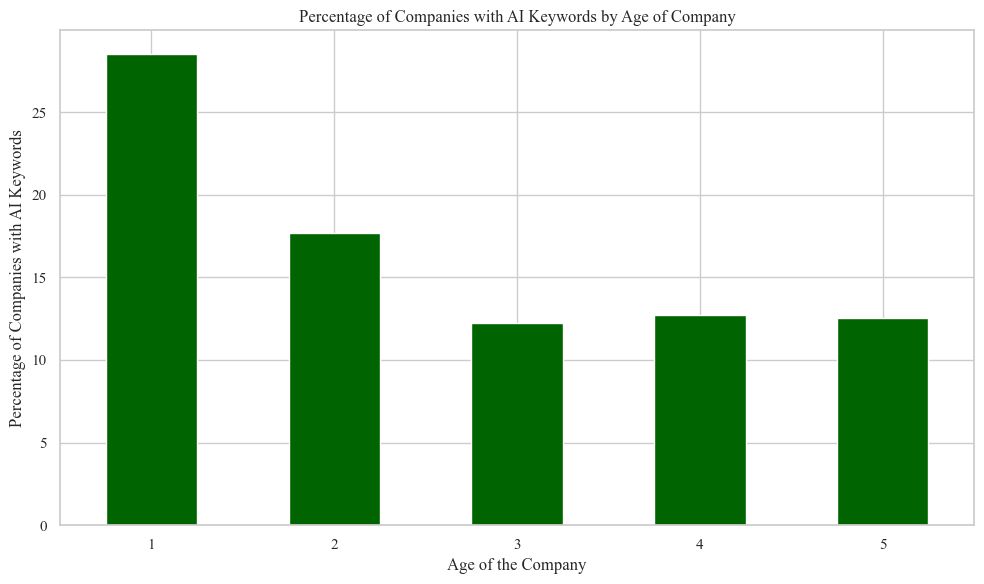

In [512]:
# Total number of companies
total_companies = len(scraped_df)

# Selecting only companies with keywords
keywords_only = scraped_df[scraped_df['keyword_bin'] == True]
number_with_keywords = len(keywords_only)

# Calculating mean and sum
mean_keywords = keywords_only['ai_keyword_count'].mean().round(2)
sum_keywords = keywords_only['ai_keyword_count'].sum().round(2)

# Calculating the percentage of companies with AI keywords
percentage_with_keywords = (number_with_keywords / total_companies * 100)

# Printing results
print(f"Total Number of Companies: {total_companies}")
print(f"Number of Companies with AI Keywords: {number_with_keywords}")
print(f"Percentage of Companies with AI Keywords: {percentage_with_keywords}%")
print(f"With on average {mean_keywords} keywords.")
print(f"Employing a total of {sum_keywords} keywords.")

# Grouping by 'age' to count total companies and companies with keywords in each age group
total_by_age = scraped_df.groupby('age').size()
keywords_by_age = keywords_only.groupby('age').size()

# Calculating the percentage of companies with keywords for each age group
percentage_by_age = (keywords_by_age / total_by_age * 100).round(2)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
percentage_by_age.plot(kind='bar', color='darkgreen')
plt.xlabel('Age of the Company')
plt.ylabel('Percentage of Companies with AI Keywords')
plt.title('Percentage of Companies with AI Keywords by Age of Company')
plt.xticks(rotation=0)
plt.tight_layout()

# Showing the plot
plt.show()


In [513]:
display(percentage_by_age)

age
1    28.52
2    17.70
3    12.25
4    12.75
5    12.56
dtype: float64

In [514]:
# Splitting the entries, stripping spaces, and flattening the list from the 'matched_keywords' column
all_keywords_final = [keyword.strip() for entry in keywords_only['matched_keywords'] if isinstance(entry, str) for keyword in entry.split(',')]

# Counting the frequency of each keyword
keyword_counts_final = Counter(all_keywords_final)

# Converting the keyword counts to a dataframe
df_keyword_counts_final = pd.DataFrame(keyword_counts_final.items(), columns=['Keyword', 'Frequency'])

# Sorting the dataframe by frequency in descending order
df_keyword_counts_final = df_keyword_counts_final.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Displaying the dataframe
print(df_keyword_counts_final)

                        Keyword  Frequency
0                            ai        789
1              machine learning        344
2       artificial intelligence        311
3                            ml        142
4                 deep learning         63
5   natural language processing         43
6                       chatbot         39
7            sentiment analysis         23
8                neural network         20
9                learning model         12
10                  data mining         12
11         machine intelligence         10
12       reinforcement learning          7
13           learning algorithm          5
14          supervised learning          5
15        unsupervised learning          5
16          logistic regression          5
17                decision tree          4
18          pattern recognition          3
19           feature extraction          3
20          feature engineering          3
21          cognitive computing          3
22         

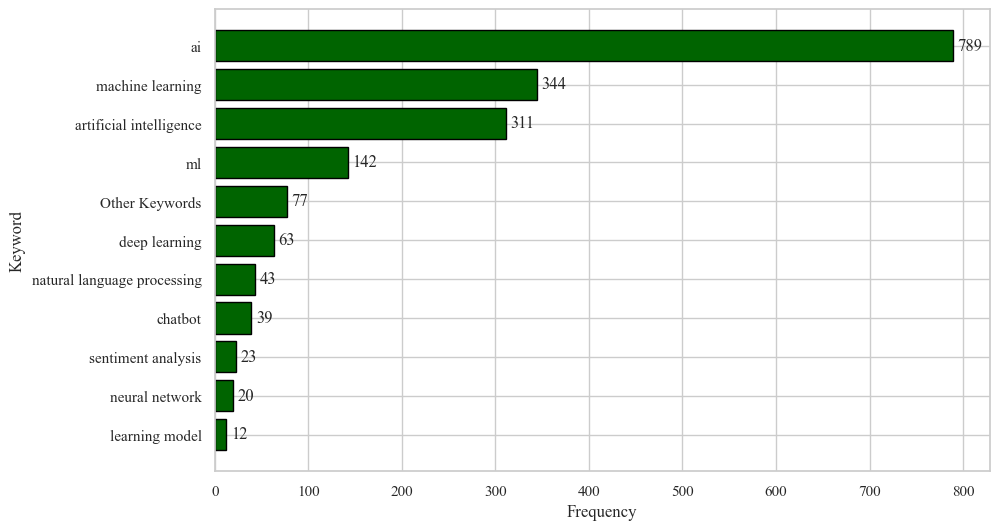

In [515]:
# Extracting the top 10 most frequent keywords
top_10_keywords = df_keyword_counts_final.head(10)

# Summing the frequencies of the rest of the keywords
others_frequency = df_keyword_counts_final.iloc[10:]['Frequency'].sum()

# Adding "Others" to the top 10 dataframe
top_10_keywords = pd.concat([top_10_keywords, pd.DataFrame([{'Keyword': 'Other Keywords', 'Frequency': others_frequency}])], ignore_index=True)

# Sorting the DataFrame by frequency in ascending order
top_10_keywords = top_10_keywords.sort_values(by='Frequency', ascending=True).reset_index(drop=True)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 12
bars = plt.barh(top_10_keywords['Keyword'], top_10_keywords['Frequency'], color='darkgreen', edgecolor='black')

# Adding the number of occurrences at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2, str(int(width)), va='center')

plt.xlabel('Frequency')
plt.ylabel('Keyword')

# Saving and Displaying the plot
plt.savefig('Plots/Descriptive Statistics/Top Keywords.png', dpi=300, bbox_inches='tight')
plt.show()


### Position

In [516]:
# Load the set from JSON file
with open('Data/Working Dataframes/keywords_final.json', 'r') as f:
    loaded_list = json.load(f)
    keywords_final = set(loaded_list)


In [517]:
scraped_df.dropna(subset = 'text_preprocessed', inplace = True)

# Collecting keyword position data grouped by company
keyword_position = build_automaton_and_search(scraped_df, keywords_final)

# Merging the position analysis results to scraped_df
scraped_df_keywords= pd.merge(scraped_df, keyword_position, on = 'website', how = 'left')
scraped_df_keywords.dropna(subset = 'first_keyword_position', inplace = True)



In [518]:
# Repeating the keyword position collection for each keyword across the whole dataframe
keyword_position_long = build_automaton_and_search_long_format(scraped_df, keywords_final)
display(keyword_position_long.head())

# Merging the position analysis results to scraped_df
scraped_df_keywords_long= pd.merge(scraped_df, keyword_position_long, on = 'website', how = 'left')
scraped_df_keywords_long.dropna(subset = 'keyword', inplace = True)

,keyword,position,position_pct,website
0,ai,86,52.439024,https://grammable.ai
1,ai,14,1.931034,https://deltainfotek.com/
2,ai,33,4.551724,https://deltainfotek.com/
3,ai,113,15.586207,https://deltainfotek.com/
4,ai,132,18.206897,https://deltainfotek.com/


In [519]:
# Grouping by 'AI_bin' and calculating the relative average and median 'position_pct'
keyword_position_long_AI = scraped_df_keywords_long.groupby('AI_bin')['position_pct'].agg(['mean', 'median']).reset_index()

# Grouping by 'AI_bin' and calculating the absolute average and median 'position'
keyword_position_long_AI_abs = scraped_df_keywords_long.groupby('AI_bin')['position'].agg(['mean', 'median']).reset_index()

# Merging the two grouped dataframes
keyword_position_long_AI = pd.merge(keyword_position_long_AI, keyword_position_long_AI_abs, on='AI_bin', how='left')

# Renaming the columns for clarity
keyword_position_long_AI.rename(columns={
    'mean_x': 'Average Keyword Position (%)', 
    'median_x': 'Median Keyword Position (%)',
    'mean_y': 'Average Keyword Position (abs)', 
    'median_y': 'Median Keyword Position (abs)'
}, inplace=True)

# Calculating the overall average and median for 'position_pct' and 'position'
overall_mean_pct = scraped_df_keywords_long['position_pct'].mean()
overall_median_pct = scraped_df_keywords_long['position_pct'].median()
overall_mean_abs = scraped_df_keywords_long['position'].mean()
overall_median_abs = scraped_df_keywords_long['position'].median()

# Creating a DataFrame for the overall average and median
overall_stats = pd.DataFrame({
    'AI_bin': ['Overall'],
    'Average Keyword Position (%)': [overall_mean_pct],
    'Median Keyword Position (%)': [overall_median_pct],
    'Average Keyword Position (abs)': [overall_mean_abs],
    'Median Keyword Position (abs)': [overall_median_abs]
})

# Appending the overall stats to the grouped stats using pd.concat
keyword_position_long_AI = pd.concat([keyword_position_long_AI, overall_stats], ignore_index=True)

# Displaying the table
display(keyword_position_long_AI)


,AI_bin,Average Keyword Position (%),Median Keyword Position (%),Average Keyword Position (abs),Median Keyword Position (abs)
0,False,47.319628,46.206897,336.849827,319.0
1,True,45.360756,42.932629,317.170186,274.0
2,Overall,45.822212,43.717123,321.806162,282.0


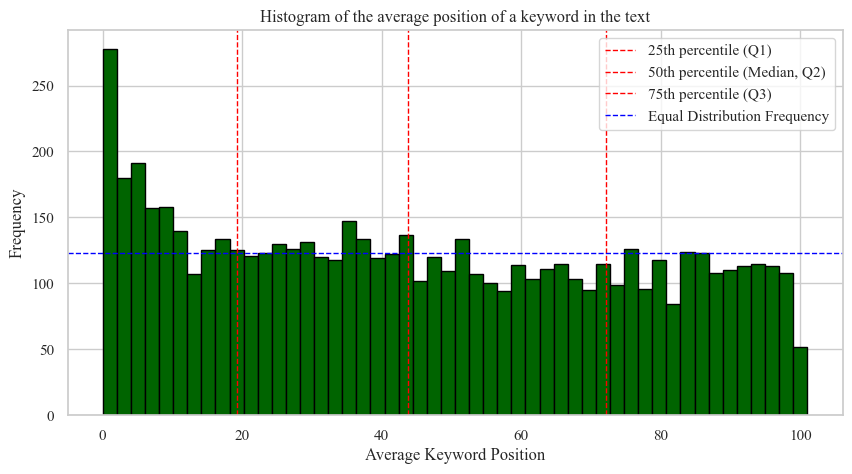

25th percentile (Q1): 19.19958421402007
50th percentile (Median, Q2): 43.71712306286647
75th percentile (Q3): 72.14588859416445
Mean: 45.82221166267339


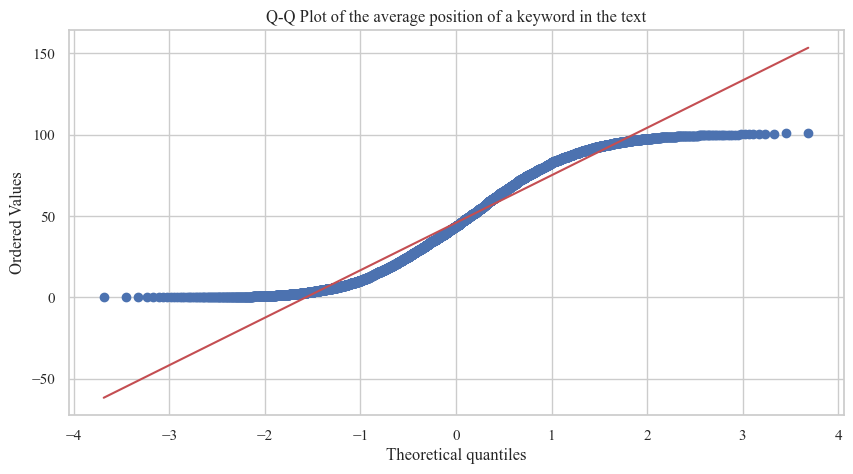

Skewness: 0.14062726316803048, Kurtosis: -1.2232660037608567


In [520]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Calculating quartiles
quartiles = scraped_df_keywords_long['position_pct'].quantile([0.25, 0.5, 0.75])
q1, q2, q3 = quartiles[0.25], quartiles[0.5], quartiles[0.75]

# Calculating mean
mean_value = scraped_df_keywords_long['position_pct'].mean()

# Setting number of bins
num_bins = 50

# Setting up histogram data
hist_data, bin_edges = np.histogram(scraped_df_keywords_long['position_pct'], bins=num_bins)

# Calculating the frequency of an equal distribution
equal_freq = len(scraped_df_keywords_long) / num_bins

# Creating a histogram and adding quartile lines and a mean line
plt.figure(figsize=(10, 5))
plt.hist(scraped_df_keywords_long['position_pct'], bins=num_bins, edgecolor='black', color='darkgreen')
plt.axvline(q1, color='red', linestyle='dashed', linewidth=1, label='25th percentile (Q1)')
plt.axvline(q2, color='red', linestyle='dashed', linewidth=1, label='50th percentile (Median, Q2)')
plt.axvline(q3, color='red', linestyle='dashed', linewidth=1, label='75th percentile (Q3)')
plt.axhline(equal_freq, color='blue', linestyle='dashed', linewidth=1, label='Equal Distribution Frequency')

# Labeling the histogram
plt.title('Histogram of the average position of a keyword in the text')
plt.xlabel('Average Keyword Position')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Plots/Descriptive Statistics/Histogramm Keyword Position.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# Printing the percentage borders of each quartile
print(f'25th percentile (Q1): {q1}')
print(f'50th percentile (Median, Q2): {q2}')
print(f'75th percentile (Q3): {q3}')
print(f'Mean: {mean_value}')


# Creating a Q-Q Plot to highlight the distribution 
plt.figure(figsize=(10, 5))
stats.probplot(scraped_df_keywords_long['position_pct'], dist="norm", plot=plt)
plt.title('Q-Q Plot of the average position of a keyword in the text')
plt.show()

# Printing the skewness and kurtosis of the graph
skewness = stats.skew(scraped_df_keywords_long['position_pct'])
kurtosis = stats.kurtosis(scraped_df_keywords_long['position_pct'])
print(f'Skewness: {skewness}, Kurtosis: {kurtosis}')



Mann-Whitney U Test statistics=3602001.500, p=0.000
Different distribution (reject H0)


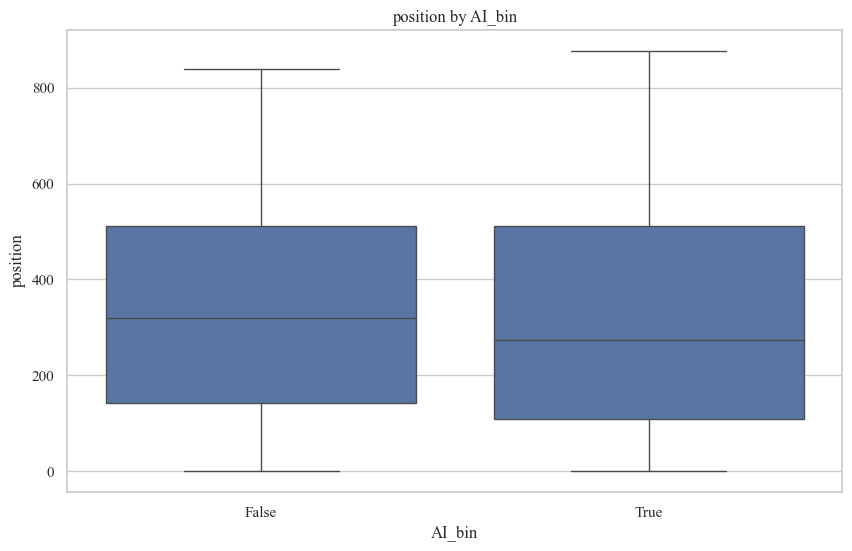

In [521]:
# Analizing the difference in keyword positioning between companies in the AI industry and all other industries
analyze_by_feature(scraped_df_keywords_long, 'position', 'AI_bin')

### Text Length

Before analyzing website the text, I remove strong outliers to ensure validity.

In [522]:
df_text = scraped_df.copy()
print(f"Number of companies before cleaning: {len(df_text)}")

df_text['z_score_text'] = zscore(df_text['text_len'])
df_text = df_text[df_text['z_score_text'] < 2]

print(f"Number of companies after cleaning text outliers: {len(df_text)}")

Number of companies before cleaning: 7945
Number of companies after cleaning text outliers: 7669


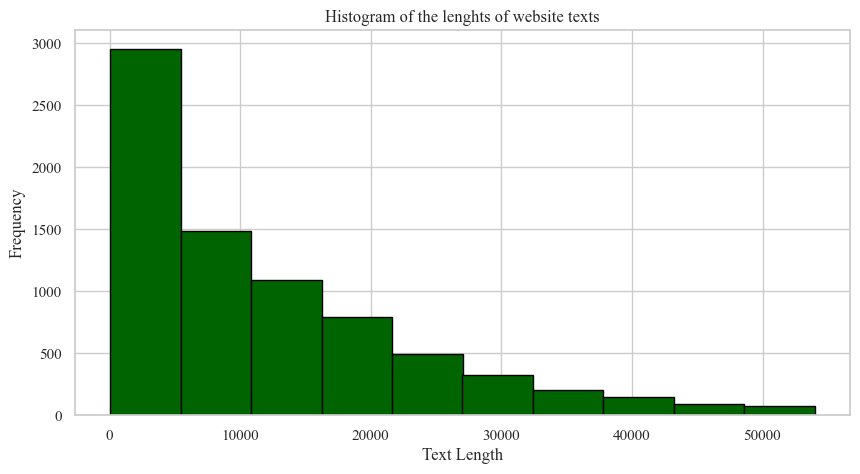

In [523]:
# Plotting a histogram to show text length distribution
plt.figure(figsize=(10, 5))
plt.hist(df_text['text_len'], bins=10, edgecolor='black', color = 'darkgreen')
plt.title('Histogram of the lenghts of website texts')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [524]:
print(f"Average text length {df_text['text_len'].mean()}")

Average text length 11831.490937540748


## Startups

### Summary Statistics

In [525]:
scraped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7945 entries, 0 to 8366
Data columns (total 46 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Unnamed: 0.1                            7945 non-null   int64         
 1   company                                 7945 non-null   object        
 2   Founded Date                            7945 non-null   datetime64[ns]
 3   website                                 7945 non-null   object        
 4   Headquarters Location                   7945 non-null   object        
 5   Industry Groups                         7945 non-null   object        
 6   Industries                              7945 non-null   object        
 7   Full Description                        4778 non-null   object        
 8   Number of Employees                     7945 non-null   object        
 9   Number of Funding Rounds                7945 non-null   f

In [526]:
# Creating an overview with summary statistics
summary_stats = scraped_df.describe().transpose()

# Manually computing statistics for binary columns
binary_columns = ['keyword_bin', 'funding_bin']
binary_summary = pd.DataFrame({
    'mean': scraped_df[binary_columns].mean(),
    'std': scraped_df[binary_columns].std(),
    'min': scraped_df[binary_columns].min(),
    'max': scraped_df[binary_columns].max()
})

# Combining both numeric and binary summaries
summary_statistics_combined = pd.concat([summary_stats[['mean', 'std', 'min', 'max']], binary_summary])

# Creating a table 
final_summary = summary_statistics_combined.loc[
    ['text_len', 'ai_keyword_count', 'Total Funding Amount Currency (in USD)', 'keyword_bin', 'age', 'funding_bin']
].rename(index={
    'text_len': 'Website text length',
    'ai_keyword_count': 'Number of Keywords',
    'Total Funding Amount Currency (in USD)': 'Total Funding Amount (in USD)',
    'keyword_bin': 'Gets Keyword Bin',
    'age': 'Age',
    'funding_bin': 'Gets Funding Bin'
})

#Exporting the final table to Excel
final_summary.to_excel('Exports/Summary Statistics.xlsx')

# Displaying the table
display(final_summary)


,mean,std,min,max
Website text length,14473.294525,19779.734951,50.0,493990.0
Number of Keywords,0.772058,3.516044,0.0,71.0
Total Funding Amount (in USD),90200.014223,710441.54412,0.0,16000000.0
Gets Keyword Bin,0.136816,0.343674,False,True
Age,3.747011,1.108848,1.0,5.0
Gets Funding Bin,0.067338,0.250622,False,True


Summary stats of all startups with funding

In [527]:
# Creating another summary statistics table only for startups with funding
funded_stats = scraped_df[scraped_df['funding_bin']== 1]
summary_stats_funding = funded_stats.describe().transpose()

# Manually computing statistics for binary columns
binary_columns = ['keyword_bin', 'funding_bin']
binary_summary = pd.DataFrame({
    'mean': funded_stats[binary_columns].mean(),
    'std': funded_stats[binary_columns].std(),
    'min': funded_stats[binary_columns].min(),
    'max': funded_stats[binary_columns].max()
})

# Combine both numeric and binary summaries
summary_statistics_combined = pd.concat([summary_stats_funding[['mean', 'std', 'min', 'max']], binary_summary])

# Creating a table 
final_summary = summary_statistics_combined.loc[
    ['text_len', 'ai_keyword_count', 'Total Funding Amount Currency (in USD)', 'keyword_bin', 'age', 'funding_bin']
].rename(index={
    'text_len': 'Website text length',
    'ai_keyword_count': 'Number of Keywords',
    'Total Funding Amount Currency (in USD)': 'Total Funding Amount (in USD)',
    'keyword_bin': 'Gets Keyword Bin',
    'age': 'Age',
    'funding_bin': 'Gets Funding Bin'
})

#Exporting the final table to Excel
final_summary.to_excel('Exports/Summary Statistics.xlsx')

# Displaying the table
display(final_summary)


,mean,std,min,max
Website text length,11087.272897,20180.827116,50.0,284865.0
Number of Keywords,0.91215,3.497691,0.0,32.0
Total Funding Amount (in USD),1339512.360748,2414937.397514,1000.0,16000000.0
Gets Keyword Bin,0.179439,0.384079,False,True
Age,3.319626,1.205748,1.0,5.0
Gets Funding Bin,1.0,0.0,True,True


### Last Funding Type

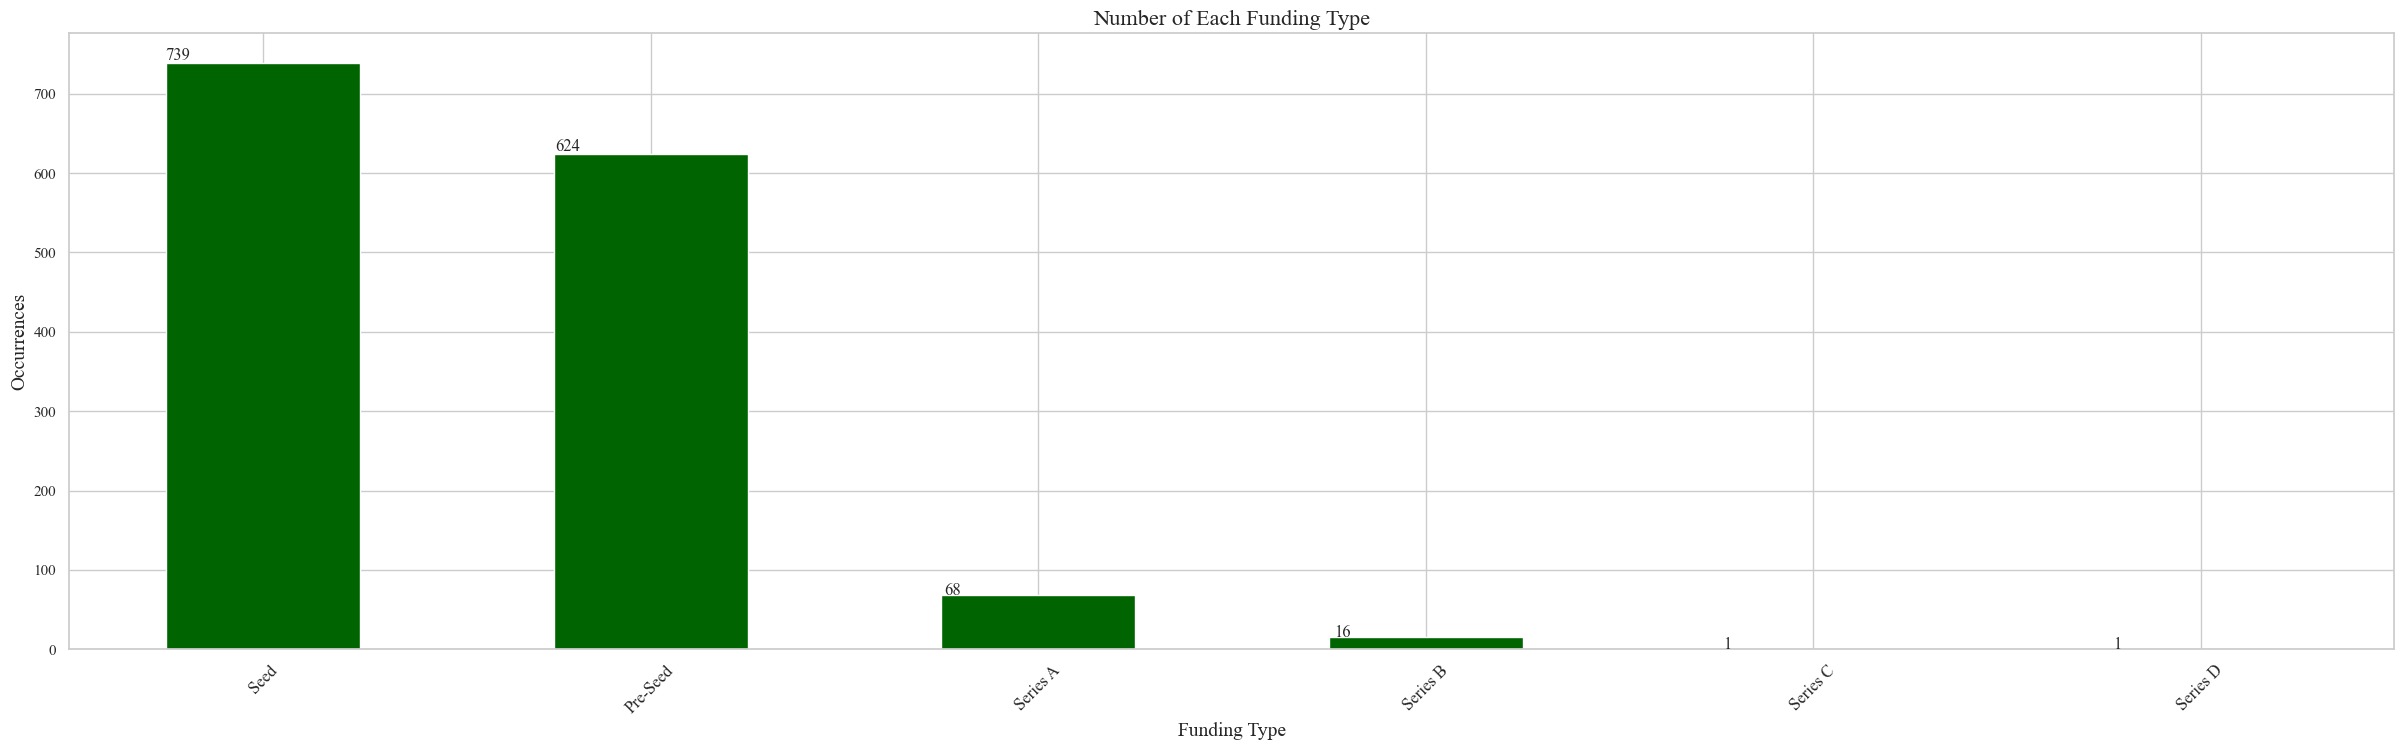

In [528]:
# Counting the occurrences of each funding type
funding_type_counts = descriptive_df['Last Funding Type'].value_counts()

# Creating the bar plot
plt.figure(figsize=(30, 8))
ax = funding_type_counts.plot(kind='bar', color='darkgreen')

# Adding the number of companies on top of the bars
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=12)

# Setting title and labels with Times New Roman font
plt.title('Number of Each Funding Type', fontname='Times New Roman', fontsize=16)
plt.xlabel('Funding Type', fontname='Times New Roman', fontsize=14)
plt.ylabel('Occurrences', fontname='Times New Roman', fontsize=14)
plt.xticks(rotation=45, fontname='Times New Roman', fontsize=12)

# Show the plot
plt.show()


### Age

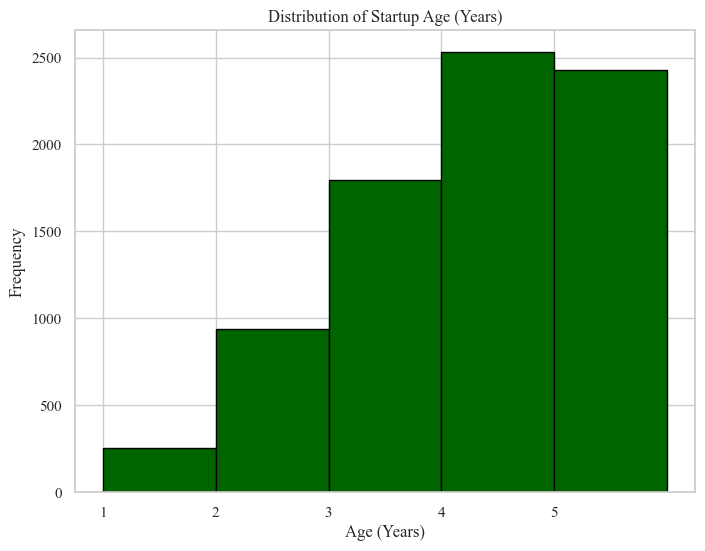

In [529]:
# Creating the histogram for Company Ages
plt.figure(figsize=(8, 6))

# Setting the bins to align with integer ages
bins = [1, 2, 3, 4, 5, 6]

# Initializing plot
sns.histplot(scraped_df['age'], bins=bins, kde=False, color='darkgreen', edgecolor='black', alpha=1)
plt.xticks(bins[:-1])  # Adjust x-ticks to match the integer bins
plt.title('Distribution of Startup Age (Years)')
plt.xlabel('Age (Years)')
plt.ylabel('Frequency')

# Displaying the Plot
plt.savefig('Plots/Descriptive Statistics/Age Distribution', dpi = 300, bbox_inches = 'tight')
plt.show()

In [530]:
# Displaying age distribution statistics
age_distribution = descriptive_df['age'].describe()
print("Age Distribution:\n", age_distribution)
print(f"Median Age: {descriptive_df['age'].median()}")

Age Distribution:
 count    8367.000000
mean        3.744592
std         1.108354
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: age, dtype: float64
Median Age: 4.0


### Employees

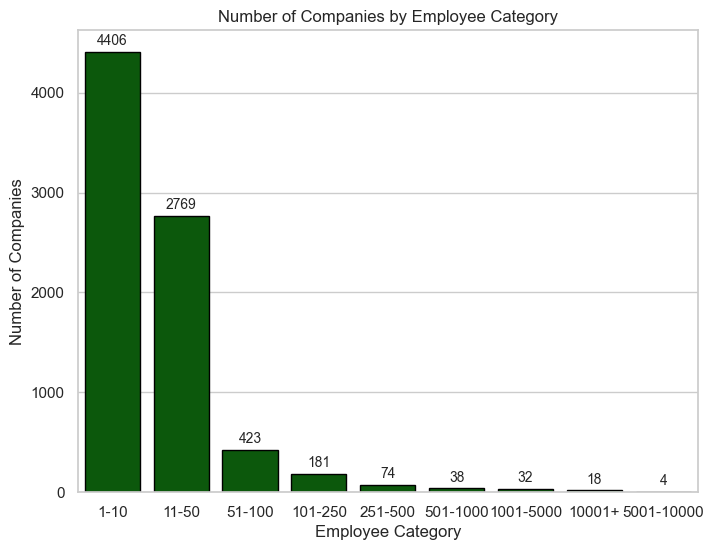

In [531]:
# Preparing data summaries
employee_summary = scraped_df['Number of Employees'].value_counts()

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Resetting the index to turn the index into a regular column
employee_summary = employee_summary.reset_index()

# Creating a new column 'Order' to define the custom sorting
employee_summary['Order'] = employee_summary['Number of Employees'].map(ordinal_map)

# Sorting the DataFrame by 'Order' column
employee_summary_sorted = employee_summary.sort_values('Order')

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Creating the bar chart for Employee Categories
plt.figure(figsize=(8, 6))
barplot = sns.barplot(
    x='Number of Employees',
    y='count',
    data=employee_summary_sorted,
    color='darkgreen',
    edgecolor='black',
    alpha=1
)

# Adding the numbers on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     size=10,
                     xytext=(0, 8),
                     textcoords='offset points')

plt.title('Number of Companies by Employee Category')
plt.xlabel('Employee Category')
plt.ylabel('Number of Companies')

# Displaying and saving the plot
plt.savefig('Plots/Descriptive Statistics/Employee Distribution.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Funding (Total)

In [532]:
# Calculating the mean total funding amount
print(f"Mean Total Funding amount: {scraped_df['Total Funding Amount Currency (in USD)'].mean().round(3)}")
print(f"Number of startups with funding: {len(scraped_df[scraped_df['funding_bin'] == 1])}")

Mean Total Funding amount: 90200.014
Number of startups with funding: 535


After gaining a first overview of the founding data, I visualize the distribution with a histogram

/var/folders/xt/0h_f_zjs1hvcdg6rdl1hs5_c0000gn/T/ipykernel_89892/3799466138.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['log_Total Funding Amount USD'] = np.log10(filtered_df['Total Funding Amount Currency (in USD)'])


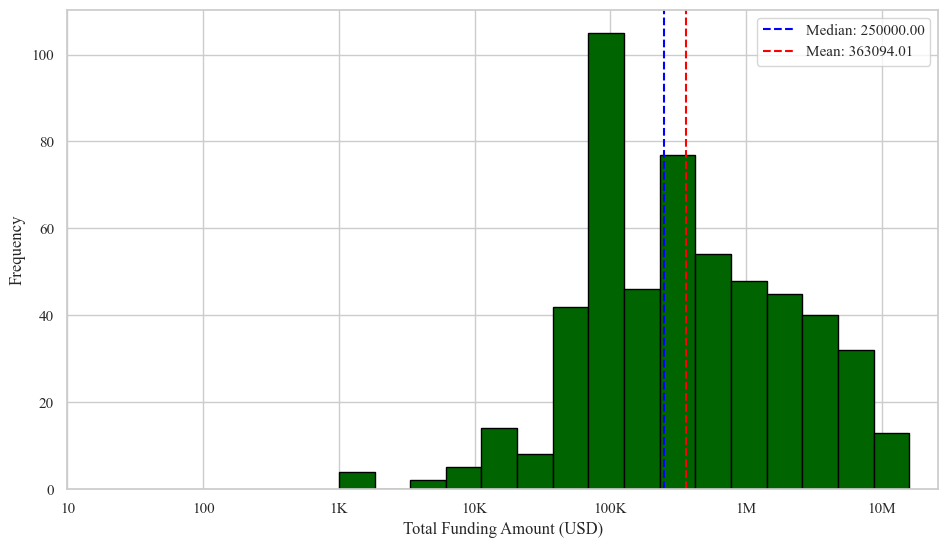

In [533]:
#Setting the font
times_new_roman_font = {'fontname':'Times New Roman'}

# Filteing the dataframe to include only companies with funding
filtered_df = scraped_df[scraped_df['Total Funding Amount Currency (in USD)'] > 0]

# Converting funding amounts to a log scale to handle skewness and large outliers
filtered_df['log_Total Funding Amount USD'] = np.log10(filtered_df['Total Funding Amount Currency (in USD)'])

# Calculating median and mean on the log-transformed scale
median_log_funding = filtered_df['log_Total Funding Amount USD'].median()
mean_log_funding = filtered_df['log_Total Funding Amount USD'].mean()

#### Creating the plot
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Creating the histogram for Total Funding Amount
plt.figure(figsize=(10, 6)) 
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 24

sns.histplot(filtered_df['log_Total Funding Amount USD'], kde=False, color='darkgreen', edgecolor='black', alpha=1)

# Addin lines for median and mean
plt.rcParams["font.family"] = "Times New Roman"
plt.axvline(median_log_funding, color='blue', linestyle='dashed', linewidth=1.5, label=f'Median: {10**median_log_funding:.2f}')
plt.axvline(mean_log_funding, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {10**mean_log_funding:.2f}')

# Setting custom tick marks and labels for the x-axis
tick_marks = [1, 2, 3, 4, 5, 6, 7]  # Log scale values
tick_labels = ['10', '100', '1K', '10K', '100K', '1M', '10M']  # Corresponding actual scale values
plt.xticks(tick_marks, tick_labels)

# Setting titles and labels
plt.xlabel('Total Funding Amount (USD)')
plt.ylabel('Frequency')
plt.legend()  

# Displaying and saving the plot
plt.tight_layout()
plt.savefig('Plots/Descriptive Statistics/Funding_Histogram.png', dpi=300, bbox_inches='tight')
plt.show()


In [581]:
# Dislaying distribution statistics
funding_distribution = scraped_df['Total Funding Amount Currency (in USD)'].describe()
print("Funding Distribution:")
display(funding_distribution)

Funding Distribution:


count    7.945000e+03
mean     9.020001e+04
std      7.104415e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.600000e+07
Name: Total Funding Amount Currency (in USD), dtype: float64

## Industry Groups
Next, I take a closer look at the different industry groups and how startups with AI keywords are distributed among them.

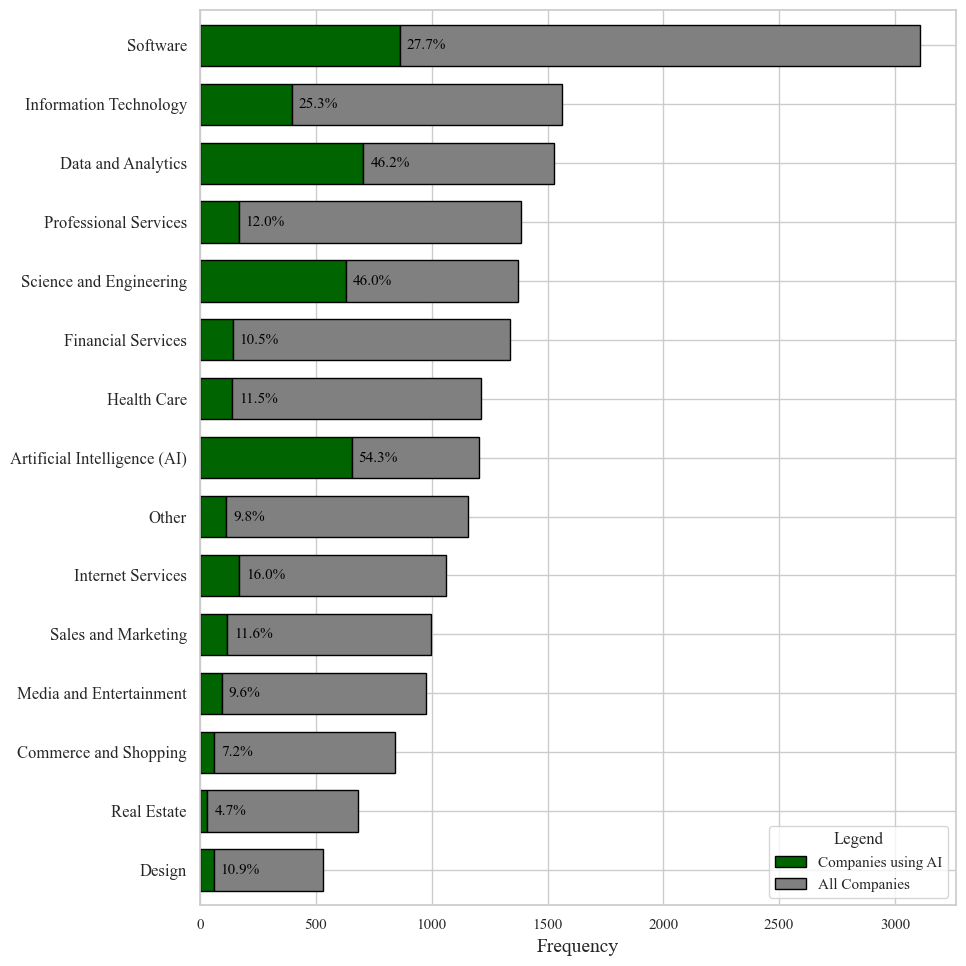

In [535]:
# Extracting the different Industry Group tags from each startup
tags_total = scraped_df['Industry Groups'].str.split(',', expand=True).stack().str.strip()
tag_counts_total = tags_total.value_counts()

# Subsetting the companies that use AI keywords and extracting their industry groups
keyword_true_data = scraped_df[scraped_df['keyword_bin'] == True]
tags_keyword_true = keyword_true_data['Industry Groups'].str.split(',', expand=True).stack().str.strip()
tag_counts_keyword_true = tags_keyword_true.value_counts()

# Creating a dataframe for the total counts and one for the keyword true counts
df_total = tag_counts_total.rename('All Companies').to_frame()
df_keyword_true = tag_counts_keyword_true.rename('Companies using AI').to_frame()

# Merging the dataframes on their industry groups
merged_df = df_total.join(df_keyword_true, how='outer').fillna(0) 

# Adjusting 'All Companies' to only reflect non-AI companies
merged_df['All Companies'] = merged_df['All Companies'] - merged_df['Companies using AI']

# Calculating the percentage of companies using AI
merged_df['Percentage'] = (merged_df['Companies using AI'] / (merged_df['All Companies'] + merged_df['Companies using AI']) * 100)

# Adding a new column 'Total' to sort by total industry group size
merged_df['Total'] = merged_df['All Companies'] + merged_df['Companies using AI']
merged_df.sort_values('Total', ascending=False, inplace=True)

# Selecting the top 20 industry groups after sorting
merged_top_20 = merged_df.head(15)[['Companies using AI', 'All Companies', 'Percentage', 'Total']]

# Sorting the merged_top_20 by the sum of 'Companies using AI' and 'All Companies' in descending order for the graph
merged_top_20 = merged_top_20.sort_values('Total', ascending=True)

# Creating the stacked barplot
fig, ax = plt.subplots(figsize=(10, 10))
bars = merged_top_20[['Companies using AI', 'All Companies']].plot(kind='barh', stacked=True, color=['darkgreen', 'grey'], edgecolor='black', ax=ax, width=0.7)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 18
font = {'fontname':'Times New Roman'}

# Setting the labels
ax.set_xlabel('Frequency', fontsize=14)
ax.set_yticks(range(len(merged_top_20)))
ax.set_yticklabels(merged_top_20.index, rotation=0, ha='right', fontsize=12, **font)

# Adding the percentage values of startups using AI keywords on the bars
for i, (idx, row) in enumerate(merged_top_20.iterrows()):
    ai_width = row['Companies using AI']
    percentage = row['Percentage']
    if ai_width > 0:
        # Place the annotation at the end of the 'Companies using AI' segment
        ax.annotate(f'{percentage:.1f}%', xy=(ai_width, i), xytext=(5, 0), textcoords="offset points",
                    ha='left', va='center', color='black', fontsize=11)

# Dispalying and saving the plot
plt.legend(title='Legend')
plt.tight_layout()
plt.savefig('Plots/Descriptive Statistics/Industry Distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [580]:
display(merged_top_20)

,Companies using AI,All Companies,Percentage,Total
Design,58,474,10.902256,532
Real Estate,32,648,4.705882,680
Commerce and Shopping,61,781,7.244656,842
Media and Entertainment,94,881,9.641026,975
Sales and Marketing,116,881,11.634905,997
Internet Services,170,893,15.992474,1063
Other,113,1043,9.775087,1156
Artificial Intelligence (AI),654,550,54.318937,1204
Health Care,139,1072,11.478117,1211
Financial Services,141,1197,10.538117,1338


Additionally, I calculate and export the number of keywords of each industry. When interpreting the number one has to keep in mind that most companies have multiple industry groups. Therefore, the keywords get counted multiple times, resulting in a significantly higher number of keywords.

In [536]:
# Extracting the Industry groups
tags_keyword_true = keyword_true_data['Industry Groups'].str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)

# Converting the tags to a DataFrame
tags_keyword_true_df = tags_keyword_true.to_frame(name='Industry Groups')

# Mapping 'ai_keyword_count' for each row
tags_keyword_true_df['ai_keyword_count'] = tags_keyword_true_df.index.map(keyword_true_data['ai_keyword_count'])

# Grouping by 'Industry Groups' and summing up 'ai_keyword_count'
tags_keyword_true_df = tags_keyword_true_df.groupby('Industry Groups').sum()

# Sorting the DataFrame in descending order
tags_keyword_true_df = tags_keyword_true_df.sort_values(by='ai_keyword_count', ascending=False)

# Displaying and saving the dataframe
display(tags_keyword_true_df)
tags_keyword_true_df.to_excel('Documentation/Industry Group Distribution.xlsx')


,ai_keyword_count
Industry Groups,
Software,5409.0
Data and Analytics,4840.0
Artificial Intelligence (AI),4689.0
Science and Engineering,4561.0
Information Technology,2301.0
Professional Services,984.0
Internet Services,825.0
Hardware,811.0
Health Care,686.0


# Testing Control Variables
After providing first descriptive statistics, I start setting up the analysis, by engineering the features and testing the correlation of the control variables.

## Feature Engineering
The full scraped_df dataset is not suitable for analyzing models. Therefore, I use a fresh copy of the dataset, drop unneded columns and apply the same data exlusion and cleaning measures as I did on scraped_df.
To account for grave outliers in funding, I apply a z-score of +- 4, based on the recommendations of Hair et al. (2014, p. 65) [Full source can be found in the list of references of my paper]

In [537]:
# Preparing the dataset by removing object-data
df_ML = df.drop(columns=['Headquarters State', 'matched_keywords', 'closest_snapshot'])
print(len(df_ML))


# Removing outliers based on the z-scores of total funding amount
print(f"Number of startups before outlier cleaning {len(df_ML)}")
df_ML['z_score_count'] = zscore(df_ML['Total Funding Amount Currency (in USD)'])
df_ML = df_ML[df_ML['z_score_count'] < 4]
df_ML = df_ML[df_ML['z_score_count'] > -4]
print(f"Number of startups remaining after outlier cleaning {len(df_ML)}")

# Filtering rows with up to one funding round
df_ML = df_ML[df_ML['Number of Funding Rounds'] < 2]

print(f"Number of startups to analyze: {len(df_ML)}")
df_ML.head()

8367
Number of startups before outlier cleaning 8367
Number of startups remaining after outlier cleaning 8335
Number of startups to analyze: 7953


,Unnamed: 0,Founded Date,Industry Groups,Number of Funding Rounds,Last Funding Amount Currency (in USD),Total Funding Amount Currency (in USD),age,founding_year,source_x,text_len,...,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022,Last Funding Type ORD,Series_A_bin,Number of Employees ORD,z_score,z_score_count
0,2,2021-08-01,Software,1.0,0.0,0.0,2,2021,0,103.0,...,False,False,False,True,False,1.0,False,1.0,-0.085751,-0.085751
1,3,2019-01-01,"Commerce and Shopping, Education, Manufacturing",0.0,0.0,0.0,5,2019,0,7306.0,...,False,True,False,False,False,0.0,False,3.0,-0.085751,-0.085751
2,4,2020-01-01,"Clothing and Apparel, Commerce and Shopping, C...",0.0,0.0,0.0,4,2020,0,195537.0,...,False,False,True,False,False,0.0,False,2.0,-0.085751,-0.085751
3,6,2018-07-06,Real Estate,0.0,0.0,0.0,5,2018,0,1684.0,...,True,False,False,False,False,0.0,False,3.0,-0.085751,-0.085751
4,10,2019-08-01,"Artificial Intelligence (AI), Data and Analyti...",0.0,0.0,0.0,4,2019,0,207.0,...,False,True,False,False,False,0.0,False,2.0,-0.085751,-0.085751


In [538]:
# Dropping all startups with remaining missing values
df_ML.dropna(inplace = True)
df_ML.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7949 entries, 0 to 8366
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              7949 non-null   int64  
 1   Founded Date                            7949 non-null   object 
 2   Industry Groups                         7949 non-null   object 
 3   Number of Funding Rounds                7949 non-null   float64
 4   Last Funding Amount Currency (in USD)   7949 non-null   float64
 5   Total Funding Amount Currency (in USD)  7949 non-null   float64
 6   age                                     7949 non-null   int64  
 7   founding_year                           7949 non-null   int64  
 8   source_x                                7949 non-null   int64  
 9   text_len                                7949 non-null   float64
 10  ai_keyword_count                        7949 non-null   float64
 

After trimming the data, I create dummy variables for the twenty most occurring industry groups. That way I can account for effects between industries in my models.

In [539]:
# Extracting industry groups to only include the 20 most important ones
all_groups = pd.Series([y.strip() for x in df_ML['Industry Groups'] for y in x.split(',')])
top_20_groups = all_groups.value_counts().nlargest(20).index.tolist()

In [540]:
# Setting up a function to create boolean dummy variables for each industry group
def make_dummies(row):
    groups = set(x.strip() for x in row.split(','))

    # Creating a dictionary that uses group names from top_20_groups and 'other' for the remaining groups, initialized to False
    dummies = {group: False for group in top_20_groups + ['other']}

    # Setting the dummy variable to True if the group is present in the row
    for group in groups:
        if group in top_20_groups:
            dummies[group] = True
        else:
            dummies['other'] = True  # Setting 'other' to True if the group is not in top 20
    return dummies

In [541]:
# Applying the function to each row to create a new DataFrame of boolean dummies
dummy_df = pd.DataFrame(df_ML['Industry Groups'].apply(make_dummies).tolist())

# Concatenating the original DataFrame with the new dummy variables
df_ML = pd.concat([df_ML, dummy_df], axis=1)
df_ML = df_ML.drop(columns=['Industry Groups', 'Founded Date', 'Series_A_bin', 'Other'])  # Optionally remove the original 'Industry Groups' column

# Checking the results and fixing the datatype
categorical_cols = ['Year_2018', 'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022',
                    'Software', 'Information Technology', 'Professional Services', 'Financial Services', 'Health Care',
                    'Internet Services', 'Sales and Marketing', 'Media and Entertainment', 'Data and Analytics', 
                    'Science and Engineering', 'Commerce and Shopping', 'Real Estate', 'Design', 
                    'Artificial Intelligence (AI)', 'Hardware', 'Education', 'Administrative Services', 
                    'Apps', 
                    #'Advertising',
                    #'Manufacturing',
                    'Community and Lifestyle', 
                    'other', 'funding_bin', 'keyword_bin', 'AI_bin' ]

for col in categorical_cols:
    df_ML[col] = df_ML[col].astype(bool)


In [542]:
# Adding the binary interaction effect to the dataframe 
df_ML['age_ai_interaction_bin'] = df_ML['age'] * df_ML['keyword_bin']

## Feature Overview
After creating a datframe with suitable features and values, I setup the different groups of features for the models I am about to test. For this first set of models, I chose to list only the excluded values, as I could iteratively experiment with the impact of different variables on the models' performance.

In [543]:
# Creating the control group wihtout any treatment variables
excluded_features_wo_AI = ['funding_bin', 'Number of Funding Rounds', 'Last Funding Amount Currency (in USD)', 'Total Funding Amount Currency (in USD)', 'fund_success', 'Last Funding Type ORD', 'Series_A_bin', 'Series_A_bin', 'AI_bin_2', 'source_x', 'Estimated Revenue Range', 'z_score', 'Unnamed: 0', 'ai_keyword_count', 'keyword_bin', 'AI_bin', 'Year_2018', 'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022', 'founding_year', 'closest_snapshot', 'fund_success', 'age', 'Artificial Intelligence (AI)', 'z_score_count', 'age_ai_interaction_bin']
features_wo_AI = [col for col in df_ML.columns if col not in excluded_features_wo_AI]#

# Creating the tested group of features with the number of keywords representing the signal
excluded_features = ['funding_bin', 'Number of Funding Rounds', 'Last Funding Amount Currency (in USD)', 'Total Funding Amount Currency (in USD)', 'fund_success', 'Last Funding Type ORD', 'Series_A_bin', 'Series_A_bin', 'AI_bin_2', 'source_x', 'Estimated Revenue Range', 'z_score', 'Unnamed: 0', 'AI_bin', 'Year_2018', 'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022', 'founding_year', 'closest_snapshot', 'keyword_bin', 'fund_success', 'Artificial Intelligence (AI)', 'z_score_count', 'age_ai_interaction_bin']
features = [col for col in df_ML.columns if col not in excluded_features]

# Creating the tested group of features with a binary variable for the use of keywords
excluded_features_bin = ['funding_bin', 'Number of Funding Rounds', 'Last Funding Amount Currency (in USD)', 'Total Funding Amount Currency (in USD)', 'fund_success', 'Last Funding Type ORD', 'Series_A_bin', 'Series_A_bin', 'AI_bin_2', 'source_x', 'Estimated Revenue Range', 'z_score', 'Unnamed: 0', 'AI_bin', 'Year_2018', 'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022', 'founding_year', 'closest_snapshot', 'fund_success', 'Artificial Intelligence (AI)', 'ai_keyword_count', 'z_score_count']
features_bin = [col for col in df_ML.columns if col not in excluded_features_bin]#

# Setting up the targets used for regression and classification models
target_classification = 'funding_bin'
target_regression = 'Total Funding Amount Currency (in USD)'

df_ML.head()


,Unnamed: 0,Number of Funding Rounds,Last Funding Amount Currency (in USD),Total Funding Amount Currency (in USD),age,founding_year,source_x,text_len,ai_keyword_count,funding_bin,...,Commerce and Shopping,Real Estate,Design,Education,Hardware,Apps,Administrative Services,Community and Lifestyle,other,age_ai_interaction_bin
0,2.0,1.0,0.0,0.0,2.0,2021.0,0.0,103.0,0.0,False,...,False,False,False,False,False,False,False,False,False,0.0
1,3.0,0.0,0.0,0.0,5.0,2019.0,0.0,7306.0,0.0,False,...,True,False,False,True,False,False,False,False,True,0.0
2,4.0,0.0,0.0,0.0,4.0,2020.0,0.0,195537.0,0.0,False,...,True,False,True,False,False,False,False,False,True,0.0
3,6.0,0.0,0.0,0.0,5.0,2018.0,0.0,1684.0,0.0,False,...,False,True,False,False,False,False,False,False,False,0.0
4,10.0,0.0,0.0,0.0,4.0,2019.0,0.0,207.0,0.0,False,...,False,False,False,False,True,False,False,False,False,0.0


In [544]:
# Creating a dataframe to get an overview of the values of the exlcluded features
excluded_features_overview = ['Number of Funding Rounds', 'Last Funding Amount Currency (in USD)', 'fund_success', 'Last Funding Type ORD', 'Series_A_bin', 'Series_A_bin', 'AI_bin_2', 'source_x', 'Estimated Revenue Range', 'z_score', 'Unnamed: 0', 'AI_bin', 'Year_2018', 'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022', 'founding_year', 'closest_snapshot', 'fund_success', 'Artificial Intelligence (AI)']
features_overview = [col for col in df_ML.columns if col not in excluded_features_overview]

# Creating a dataframe with descriptive statistics
feature_stats = pd.DataFrame(columns = ['Mean', 'SD', 'Min', 'Max'])
for feature in features_overview: 
    feature_stats.loc[feature] = [
    round(df_ML[feature].mean(), 2),
    round(df_ML[feature].std(), 2),
    df_ML[feature].min(),
    df_ML[feature].max()
    ]

# Displaying and saving the data
display(feature_stats)
feature_stats.to_excel('Exports/feature_stats.xlsx')

,Mean,SD,Min,Max
Total Funding Amount Currency (in USD),90154.62,710265.63,0.000000,1.600000e+07
age,3.75,1.11,1.000000,5.000000e+00
text_len,14604.96,20434.18,50.000000,4.939900e+05
ai_keyword_count,0.77,3.52,0.000000,7.100000e+01
funding_bin,0.11,0.32,0.000000,1.000000e+00
keyword_bin,0.18,0.38,0.000000,1.000000e+00
Number of Employees ORD,1.62,0.95,1.000000,8.000000e+00
z_score_count,-0.06,0.17,-0.085751,3.813664e+00
Software,0.42,0.49,0.000000,1.000000e+00
Information Technology,0.24,0.43,0.000000,1.000000e+00


# Running the Main Models
After setting up the independent and dependent variables, I start testing the models.

## OLS

In [545]:
import pandas as pd
import statsmodels.api as sm

# Ensure all feature columns are numeric and boolean columns are converted to integers
for col in df_ML.columns:
    if df_ML[col].dtype == 'bool':
        df_ML[col] = df_ML[col].astype(int)

# Drop rows with NaN values in predictors and target
df_ML.dropna(subset=features + [target_regression], inplace=True)

# Define the predictors and target variable
X = df_ML[features_bin]
y = df_ML[target_regression]

# Add a constant term to the predictors
X = sm.add_constant(X)

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(ols_model.summary())


                                      OLS Regression Results                                      
Dep. Variable:     Total Funding Amount Currency (in USD)   R-squared:                       0.011
Model:                                                OLS   Adj. R-squared:                  0.008
Method:                                     Least Squares   F-statistic:                     3.695
Date:                                    Sun, 23 Jun 2024   Prob (F-statistic):           2.75e-09
Time:                                            13:22:26   Log-Likelihood:            -1.1833e+05
No. Observations:                                    7949   AIC:                         2.367e+05
Df Residuals:                                        7924   BIC:                         2.369e+05
Df Model:                                              24                                         
Covariance Type:                                nonrobust                                         
          

Running a Regression of ordinary least squares, it becomes apparent that the linear regression is not suited to anylze the data at hand, as keywords as well as their interaction effect with age are not significant. 
Consequently, I will use a logistic regression for the analysis, for the resons explained in my thesis. 

## Logisitic Regregression - Keyword Count
After pivoting to the logisitc regression, I start with a model that analyzes the effect of keyword quantity on the funding. 

In [546]:
from statsmodels.discrete.discrete_model import Logit

First, I set up the model with just the control variables as a baseline.

In [547]:
# Ensuring that all features are numeric and boolean columns are converted to integers
for col in df_ML.columns:
    if df_ML[col].dtype == 'bool':
        df_ML[col] = df_ML[col].astype(int)

# Dropping rows with NaN values in predictors and target
df_ML.dropna(subset=features_wo_AI + [target_classification], inplace=True)

# Defining the predictors and target variable for classification
X = df_ML[features_wo_AI]
y = df_ML[target_classification]

# Adding a constant term to the predictors
X = sm.add_constant(X)

# Fitting the Logistic Regression model
logit_model = Logit(y, X).fit()

# Printing the summary of the logistic regression
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.234048
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            funding_bin   No. Observations:                 7949
Model:                          Logit   Df Residuals:                     7927
Method:                           MLE   Df Model:                           21
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                 0.05094
Time:                        13:22:27   Log-Likelihood:                -1860.4
converged:                       True   LL-Null:                       -1960.3
Covariance Type:            nonrobust   LLR p-value:                 4.150e-31
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.3606      0.150     -9.093      0.000      -1.654   

Then I add the features.

In [548]:
# Ensuring that all features are numeric and boolean columns are converted to integers
for col in df_ML.columns:
    if df_ML[col].dtype == 'bool':
        df_ML[col] = df_ML[col].astype(int)

# Dropping rows with NaN values in predictors and target
df_ML.dropna(subset=features + [target_classification], inplace=True)

# Defining the predictors and target variable for classification
X = df_ML[features]
y = df_ML[target_classification]

# Adding a constant term to the predictors
X = sm.add_constant(X)

# Fitting the Logistic Regression model
logit_model = Logit(y, X).fit()

# Printing the summary of the logistic regression
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.230148
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            funding_bin   No. Observations:                 7949
Model:                          Logit   Df Residuals:                     7925
Method:                           MLE   Df Model:                           23
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                 0.06675
Time:                        13:22:27   Log-Likelihood:                -1829.4
converged:                       True   LL-Null:                       -1960.3
Covariance Type:            nonrobust   LLR p-value:                 2.290e-42
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.3459      0.194     -1.782      0.075      -0.726   

The reuslts show that the quantity of AI-related keywords does not have a statistically significant effect on funding. 

In [549]:
# Ensuring that all features are numeric and boolean columns are converted to integers
for col in df_ML.columns:
    if df_ML[col].dtype == 'bool':
        df_ML[col] = df_ML[col].astype(int)

# Mean center the 'age' and 'ai_keyword_count' variables to increase explanatory power
df_ML['age_centered'] = df_ML['age'] - df_ML['age'].mean()
df_ML['ai_keyword_count_centered'] = df_ML['ai_keyword_count'] - df_ML['ai_keyword_count'].mean()

# Creating the interaction term using the mean-centered variables
df_ML['age_ai_interaction'] = df_ML['age_centered'] * df_ML['ai_keyword_count_centered']

# Updating the features list to include the mean-centered variables and the interaction term
features_with_interaction = features + ['age_ai_interaction']

# Dropping rows with NaN values in predictors and target
df_ML.dropna(subset=features_with_interaction + [target_classification], inplace=True)

# Defining the predictors and target variable for classification
X = df_ML[features_with_interaction]
y = df_ML[target_classification]

# Adding a constant term to the predictors
X = sm.add_constant(X)

# Fitting the Logistic Regression model
logit_model = Logit(y, X).fit()

# Printing the summary of the logistic regression
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.230139
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            funding_bin   No. Observations:                 7949
Model:                          Logit   Df Residuals:                     7924
Method:                           MLE   Df Model:                           24
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                 0.06679
Time:                        13:22:28   Log-Likelihood:                -1829.4
converged:                       True   LL-Null:                       -1960.3
Covariance Type:            nonrobust   LLR p-value:                 7.344e-42
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.3435      0.194     -1.770      0.077      -0.724   

Centering the variables as well as adding an interaction term for age and AI keyword count did not change the outcome. Both variables are not statistically significant.

## Logistic Regression Binary
Next, I analyze the overall effect of the use of AI-related keywords on the funding success with a binary variable for keywords. To better setup different models, I redefine the features positively, only listing the used variables.

In [550]:
# Ensuring that all features are numeric and boolean columns are converted to integers
for col in df_ML.columns:
    if df_ML[col].dtype == 'bool':
        df_ML[col] = df_ML[col].astype(int)

# Mean center the 'age' and 'ai_keyword_count' variables
df_ML['age_centered'] = df_ML['age'] - df_ML['age'].mean()
df_ML['ai_keyword_count_centered'] = df_ML['ai_keyword_count'] - df_ML['ai_keyword_count'].mean()

# Creating the interaction term using the mean-centered variables
df_ML['age_ai_interaction_bin'] = df_ML['age_centered'] * df_ML['keyword_bin']


# Control variables
features_wo_AI= [
    'text_len', 'Number of Employees ORD', 
    'Software', 'Data and Analytics', 'Information Technology', 'Science and Engineering', 'Professional Services', 'Financial Services', 'Health Care', 'other', 'Internet Services', 'Sales and Marketing', 
    'Media and Entertainment', 'Commerce and Shopping', 'Real Estate', 'Hardware', 'Design', 'Education', 'Apps', 'Administrative Services',
    #'Community and Lifestyle',
    ]

# Variables including AI
features_full= [
    'text_len', 'Number of Employees ORD', 'age_centered', 'keyword_bin',
    'Software', 'Data and Analytics', 'Information Technology', 'Science and Engineering', 'Professional Services', 'Financial Services', 'Health Care', 'other', 'Internet Services', 'Sales and Marketing', 
    'Media and Entertainment', 'Commerce and Shopping', 'Real Estate', 'Hardware', 'Design', 'Education', 'Apps', 'Administrative Services'
    #'Community and Lifestyle', 
    ]

# Variables including AI and the interaction term of age and keyword_bin
features_full_inter = [
    'text_len', 'Number of Employees ORD', 'age_centered', 'keyword_bin', 'age_ai_interaction_bin', 
    'Software', 'Data and Analytics', 'Information Technology', 'Science and Engineering', 'Professional Services', 'Financial Services', 'Health Care', 'other', 'Internet Services', 'Sales and Marketing', 
    'Media and Entertainment', 'Commerce and Shopping', 'Real Estate', 'Hardware', 'Design', 'Education', 'Apps', 'Administrative Services'
    #'Community and Lifestyle', 
    ]

# Number of keywords to compare other models to
features_full_quantity = [
    'text_len', 'Number of Employees ORD', 'age_centered', 'ai_keyword_count', 
    'Software', 'Data and Analytics', 'Information Technology', 'Science and Engineering', 'Professional Services', 'Financial Services', 'Health Care', 'other', 'Internet Services', 'Sales and Marketing', 
    'Media and Entertainment', 'Commerce and Shopping', 'Real Estate', 'Hardware', 'Design', 'Education', 'Apps', 'Administrative Services'
    #'Community and Lifestyle', 
    ]


### Calculating Correlation Matrix
After defining all sets of variables for the different models, I create a correlation matrix to highlight the interdependencies between the features. To identify possible multicollinearity.

In [551]:
# Creating a mapping of variable names to index numbers for better readability of the 
variable_mapping = {feature: idx + 1 for idx, feature in enumerate(features_full_inter)}

# Updating features with their corresponding indices
features_with_indices = [f'{idx + 1}: {feature}' for idx, feature in enumerate(features_full_inter)]

# Calculating the correlation matrix and p-values for all sets of features
correlation_matrix = df_ML[features_full_inter].corr()
p_values = pd.DataFrame(np.zeros((len(features_full_inter), len(features_full_inter))), columns=features_full_inter, index=features_full_inter)

for i in range(len(features_full_inter)):
    for j in range(i+1, len(features_full_inter)):
        corr, p_val = pearsonr(df_ML[features_full_inter[i]], df_ML[features_full_inter[j]])
        p_values.iloc[i, j] = p_val
        p_values.iloc[j, i] = p_val

# Rounding the values to three decimal places for better readability
correlation_matrix_rounded = correlation_matrix.round(3)

# Defining the highlighting of significant correlations
def highlight_significant_corr(value, p_val):
    if p_val < 0.05:
        return f'{value}*'
    elif p_val < 0.01:
        return f'{value}**'
    elif p_val < 0.001:
        return f'{value}***'
    else:
        return str(value)
    
correlation_matrix_highlighted = correlation_matrix_rounded.copy()

# Highlighting significant correlations
for i in range(len(features_full_inter)):
    for j in range(i, len(features_full_inter)):
        correlation_matrix_highlighted.iloc[i, j] = highlight_significant_corr(correlation_matrix_rounded.iloc[i, j], p_values.iloc[i, j])
        correlation_matrix_highlighted.iloc[j, i] = highlight_significant_corr(correlation_matrix_rounded.iloc[j, i], p_values.iloc[j, i])

# Covering the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix_rounded, dtype=bool))
correlation_matrix_lower = correlation_matrix_highlighted.mask(mask)

# Updating the correlation matrix column names with indices
correlation_matrix_lower.columns = [f'{variable_mapping[feature]}' for feature in features_full_inter]

# Calculating additional statistics
mean_values = df_ML[features_full_inter].mean().round(2)
std_values = df_ML[features_full_inter].std().round(3)
min_values = df_ML[features_full_inter].min().round(2)
max_values = df_ML[features_full_inter].max().round(2)

# Converting the statistics to a DataFrame
statistics = pd.DataFrame({
    'mean': mean_values,
    'std': std_values,
    'min': min_values,
    'max': max_values
}).T

# Updating the statistics DataFrame column names with indices
statistics.columns = correlation_matrix_lower.columns

# Concatenating the statistics DataFrame to the correlation matrix
correlation_matrix_with_stats = pd.concat([correlation_matrix_lower, statistics])

# Converting the correlation matrix to a nicely formatted plain text table
correlation_table = correlation_matrix_with_stats.to_string()

# Exporting the table to an Excel file
correlation_matrix_with_stats.to_excel('Exports/correlation_matrix_with_stats.xlsx')

# Printing the correlation table for inclusion in a scientific paper
print(correlation_table)

/var/folders/xt/0h_f_zjs1hvcdg6rdl1hs5_c0000gn/T/ipykernel_89892/3900735712.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0*' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  correlation_matrix_highlighted.iloc[i, j] = highlight_significant_corr(correlation_matrix_rounded.iloc[i, j], p_values.iloc[i, j])
/var/folders/xt/0h_f_zjs1hvcdg6rdl1hs5_c0000gn/T/ipykernel_89892/3900735712.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.075*' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  correlation_matrix_highlighted.iloc[i, j] = highlight_significant_corr(correlation_matrix_rounded.iloc[i, j], p_values.iloc[i, j])
/var/folders/xt/0h_f_zjs1hvcdg6rdl1hs5_c0000gn/T/ipykernel_89892/3900735712.py:36: FutureWarning: Setting an item of i

                                 1        2        3        4        5       6       7       8       9       10      11      12      13      14      15      16      17      18      19      20      21      22     23
text_len                       NaN      NaN      NaN      NaN      NaN     NaN     NaN     NaN     NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN    NaN
Number of Employees ORD     0.075*      NaN      NaN      NaN      NaN     NaN     NaN     NaN     NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN    NaN
age_centered                0.033*   0.051*      NaN      NaN      NaN     NaN     NaN     NaN     NaN      NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN    NaN
keyword_bin                -0.039*    -0.01  -0.063*      NaN      NaN     NaN     NaN     NaN     NaN      NaN     NaN     NaN     NaN     

Next, I calculate the variance inflation factor of each feature to furhter check for multicollinearity.

In [552]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculating VIF for each feature
X = df_ML[features_full_inter].assign(const=1)  # Add a constant for the intercept
vif_data = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Removing the constant from the VIF results
vif_data = vif_data[vif_data['Variable'] != 'const']

# Rounding the VIF values for better readability
vif_data['VIF'] = vif_data['VIF'].round(3)

# Sorting by VIF for better interpretation
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# Calculating mean and max of VIF values
mean_vif = vif_data['VIF'].mean()
max_vif = vif_data['VIF'].max()

# Printing the VIF results
print(vif_data.to_string(index=False))
print(f"\nMean VIF: {mean_vif}")
print(f"Max VIF: {max_vif}")



               Variable   VIF
     Data and Analytics 2.700
Science and Engineering 2.487
                   Apps 2.021
               Software 1.944
Administrative Services 1.836
                 Design 1.760
               Hardware 1.757
              Education 1.582
            Real Estate 1.518
      Internet Services 1.470
    Sales and Marketing 1.438
  Commerce and Shopping 1.404
Media and Entertainment 1.402
 Information Technology 1.386
  Professional Services 1.371
            Health Care 1.262
                  other 1.233
 age_ai_interaction_bin 1.231
           age_centered 1.216
     Financial Services 1.213
            keyword_bin 1.136
               text_len 1.013
Number of Employees ORD 1.012

Mean VIF: 1.5387826086956522
Max VIF: 2.7


The results show that multicollinearity is not an issue in the models, as the VIF is far under the threshold of 10, propsed by Hair et al (2014, p.200), and the correlation matrix also does not show significant correlations close to +- 1. /n 

### Model Comparison Table
Therfore, I continue with the models, setting up a table that compares their results. 

In [553]:
# Defining a function to extract the coefficients, standard errors, and p-values from the model
def extract_model_info(model, feature_names, model_name):
    coef = model.params
    std_err = model.bse
    p_values = model.pvalues

    # Including a sub-function that marks signficant results based on p-values
    def p_value_stars(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        elif p < 0.1:
            return '†'
        else:
            return ''
    
    stars = p_values.apply(p_value_stars)
    coef_with_stars = coef.round(3).astype(str) + stars

    # Creating the collumns holding the results
    summary_df = pd.DataFrame({
        model_name + ' Coeff.': coef_with_stars,
        model_name + ' SE': std_err.round(3).astype(str)
    })

    summary_df.index = feature_names
    return summary_df


# Setting the dependent variable
target_classification = 'funding_bin'  

# Fitting the models and extract information
model_summaries = []

# Model 1: Control group
X2 = sm.add_constant(df_ML[features_wo_AI])
y2 = df_ML[target_classification]
model2 = Logit(y2, X2).fit()
model_summaries.append(extract_model_info(model2, ['const'] + features_wo_AI, 'Control Group'))

# Model 2: Testing for keyword quantity
X1 = sm.add_constant(df_ML[features_full_quantity])
y1 = df_ML[target_classification]
model1 = Logit(y1, X1).fit()
model_summaries.append(extract_model_info(model1, ['const'] + features_full_quantity, 'Keyword Quantity'))

# Model 3: Keywords binary
X3 = sm.add_constant(df_ML[features_full])
y3 = df_ML[target_classification]
model3 = Logit(y3, X3).fit()
model_summaries.append(extract_model_info(model3, ['const'] + features_full, 'Keywords Binary'))

# Model 4: Keywords binary & Interaction effect
X4 = sm.add_constant(df_ML[features_full_inter])
y4 = df_ML[target_classification]
model4 = Logit(y4, X4).fit()
model_summaries.append(extract_model_info(model4, ['const'] + features_full_inter, 'Keywords & Interaction'))

# Mergeing all summaries into a single DataFrame
summary_table = model_summaries[0]
for model_summary in model_summaries[1:]:
    summary_table = summary_table.merge(model_summary, left_index=True, right_index=True, how='outer')

# Displaying and saving the results
summary_table.to_excel('Exports/Model Summary table.xlsx')
display(summary_table)


Optimization terminated successfully.
         Current function value: 0.234156
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.230242
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.229898
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.229573
         Iterations 8


,Control Group Coeff.,Control Group SE,Keyword Quantity Coeff.,Keyword Quantity SE,Keywords Binary Coeff.,Keywords Binary SE,Keywords & Interaction Coeff.,Keywords & Interaction SE
Administrative Services,-0.49*,0.234,-0.497*,0.236,-0.5*,0.236,-0.506*,0.236
Apps,0.006,0.209,0.006,0.21,-0.003,0.21,-0.008,0.21
Commerce and Shopping,-0.077,0.152,-0.071,0.153,-0.075,0.153,-0.072,0.153
Data and Analytics,0.391*,0.161,0.363*,0.164,0.338*,0.165,0.338*,0.165
Design,-0.23,0.194,-0.265,0.195,-0.283,0.195,-0.27,0.195
Education,-0.099,0.182,-0.112,0.183,-0.118,0.183,-0.112,0.183
Financial Services,-0.148,0.125,-0.142,0.126,-0.149,0.126,-0.153,0.126
Hardware,0.072,0.178,0.086,0.178,0.079,0.179,0.074,0.179
Health Care,-0.425**,0.139,-0.391**,0.139,-0.391**,0.14,-0.394**,0.14
Information Technology,-0.08,0.12,-0.071,0.121,-0.076,0.121,-0.074,0.121


## Logistic Regression Binary full results
Since the summary does not show all values of the models, I recalculated all the models by themselves for more information, if need be.

In [554]:
# Model 1: Control Model
# Defining the predictors and target variable for classification
X = df_ML[features_wo_AI]
y = df_ML[target_classification]

# Adding a constant term to the predictors
X = sm.add_constant(X)

# Fitting the Logistic Regression model
logit_model = Logit(y, X).fit()

# Printing the summary of the logistic regression
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.234156
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            funding_bin   No. Observations:                 7949
Model:                          Logit   Df Residuals:                     7928
Method:                           MLE   Df Model:                           20
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                 0.05049
Time:                        13:22:33   Log-Likelihood:                -1861.3
converged:                       True   LL-Null:                       -1960.3
Covariance Type:            nonrobust   LLR p-value:                 2.836e-31
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.3520      0.149     -9.064      0.000      -1.644   

In [555]:
## Model 2: Testing for keyword quantity
# Defining the predictors and target variable for classification
X = df_ML[features_full_quantity]
y = df_ML[target_classification]

# Adding a constant term to the predictors
X = sm.add_constant(X)

# Fitting the Logistic Regression model
logit_model = Logit(y, X).fit()

# Print the summary of the logistic regression
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.230242
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            funding_bin   No. Observations:                 7949
Model:                          Logit   Df Residuals:                     7926
Method:                           MLE   Df Model:                           22
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                 0.06637
Time:                        13:22:33   Log-Likelihood:                -1830.2
converged:                       True   LL-Null:                       -1960.3
Covariance Type:            nonrobust   LLR p-value:                 1.308e-42
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.4697      0.150     -9.783      0.000      -1.764   

In [556]:
## Model 3: Testing for keywords (binary)
# Defining the predictors and target variable for classification
X = df_ML[features_full]
y = df_ML[target_classification]

# Adding a constant term to the predictors
X = sm.add_constant(X)

# Fitting the Logistic Regression model
logit_model = Logit(y, X).fit()

# Printing the summary of the logistic regression
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.229898
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            funding_bin   No. Observations:                 7949
Model:                          Logit   Df Residuals:                     7926
Method:                           MLE   Df Model:                           22
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                 0.06776
Time:                        13:22:34   Log-Likelihood:                -1827.5
converged:                       True   LL-Null:                       -1960.3
Covariance Type:            nonrobust   LLR p-value:                 1.040e-43
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.4916      0.151     -9.902      0.000      -1.787   

In [557]:
# Model 4: Testing for keywords (binary) with Timing (interaction of age and keyword_bin)
# Defining the predictors and target variable for classification
X = df_ML[features_full_inter]
y = df_ML[target_classification]

# Adding a constant term to the predictors
X = sm.add_constant(X)

# Fitting the Logistic Regression model
logit_model = Logit(y, X).fit()

# Printing the summary of the logistic regression
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.229573
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            funding_bin   No. Observations:                 7949
Model:                          Logit   Df Residuals:                     7925
Method:                           MLE   Df Model:                           23
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                 0.06908
Time:                        13:22:34   Log-Likelihood:                -1824.9
converged:                       True   LL-Null:                       -1960.3
Covariance Type:            nonrobust   LLR p-value:                 3.386e-44
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.5020      0.151     -9.953      0.000      -1.798   

# Supplementary Analyses

After the main Models are finished, I perform supplementary analyses to better understand the underlying effects.

## Total Funding

Regarding the total amount of funding, I check the average differences between startups that use AI keywords and those that do not.

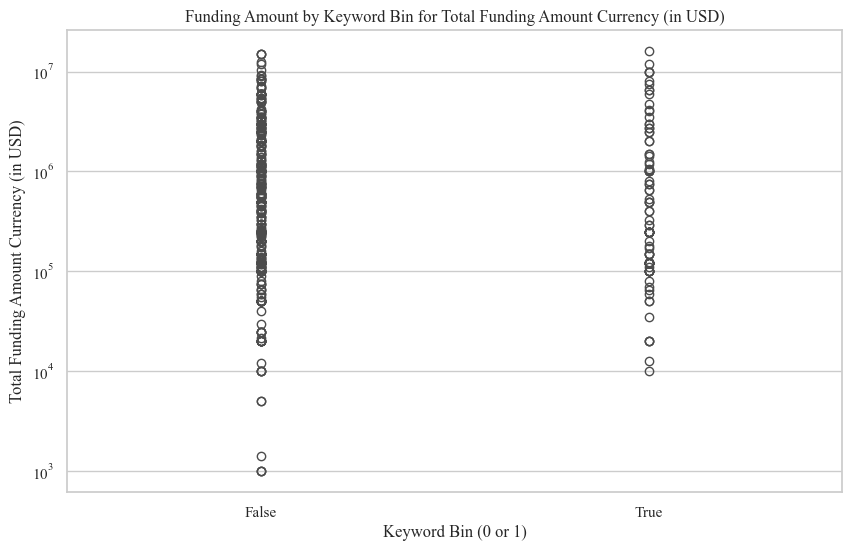

Mann-Whitney U Test statistics=3635739.500, p=0.003
Different distribution (reject H0)


In [558]:
analyze_by_keyword_bin(scraped_df, 'Total Funding Amount Currency (in USD)')

After establishing a signifcant difference in funding between companies with and without keywords, I look at the difference in mean funding amount.

In [559]:
stats_result_funding_total = calculate_stats_by_keyword_bin(scraped_df, 'Total Funding Amount Currency (in USD)')
display(stats_result_funding_total)

,keyword_bin,Mean Total Funding Amount Currency (in USD),Median Total Funding Amount Currency (in USD)
0,False,81759.443424,0.0
1,True,143452.483901,0.0


## Keyword Position
The position of each keyword wihtin the text does not influence the total funding amount.

In [560]:
# Extracting the relevant columns
position_pct = scraped_df_keywords_long['position_pct']
funding_amount = scraped_df_keywords_long['Total Funding Amount Currency (in USD)']

# Calculating the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(position_pct, funding_amount)

# Printing the results
print("Pearson correlation coefficient:", correlation)
print("P-value:", p_value)


Pearson correlation coefficient: 0.006418675875375368
P-value: 0.6152367386267014


## Keyword density

In [561]:
# Creating the feature 'Keyword density'
scraped_df['keyword_density'] = scraped_df['ai_keyword_count'] / scraped_df['text_len']

# Calculating the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(scraped_df['keyword_density'], scraped_df['Total Funding Amount Currency (in USD)'])

# Printing the results
print("Pearson correlation coefficient:", correlation)
print("P-value:", p_value)

Pearson correlation coefficient: 0.021960781272523988
P-value: 0.0503008883668886


## Timing

After finding a significant positive correlation between age and keyword use, I dive deeper into the effects. However, it is important to remember that looking at the effects by themselves, other influencing variables are not accounted for.

### Keyword count significance per year (Total funding)

In [562]:
age_list = [1,2,3,4,5]

for i in age_list: 
    data = scraped_df[scraped_df['age'] == i]
    # Calculate the Pearson correlation coefficient and p-value
    correlation, p_value = pearsonr(data['ai_keyword_count'], data['Total Funding Amount Currency (in USD)'])

    # Print the results
    print(f'For Companies that are {i} year(s) old: ')
    print("Pearson correlation coefficient:", correlation)
    print("P-value:", p_value)
    print('')

For Companies that are 1 year(s) old: 
Pearson correlation coefficient: 0.1755401868270472
P-value: 0.004850427025066166

For Companies that are 2 year(s) old: 
Pearson correlation coefficient: 0.05032166657314466
P-value: 0.12353314959073021

For Companies that are 3 year(s) old: 
Pearson correlation coefficient: 0.008953400536836202
P-value: 0.704788503155207

For Companies that are 4 year(s) old: 
Pearson correlation coefficient: 0.03621102958922257
P-value: 0.0685400406872296

For Companies that are 5 year(s) old: 
Pearson correlation coefficient: -0.01129600343745966
P-value: 0.5780576941414913



### Keyword count significance per year (Funding Success)

In [563]:
for i in age_list: 
    data = scraped_df[scraped_df['age'] == i]
    # Calculate the Pearson correlation coefficient and p-value
    print(f'For Companies that are {i} year(s) old: ')
    analyze_by_feature_no_graph(data, 'ai_keyword_count', 'funding_bin')
    print('')

For Companies that are 1 year(s) old: 
Mann-Whitney U Test statistics=4110.500, p=0.647
Same distribution (fail to reject H0)

For Companies that are 2 year(s) old: 
Mann-Whitney U Test statistics=46982.000, p=0.566
Same distribution (fail to reject H0)

For Companies that are 3 year(s) old: 
Mann-Whitney U Test statistics=107509.000, p=0.592
Same distribution (fail to reject H0)

For Companies that are 4 year(s) old: 
Mann-Whitney U Test statistics=162434.500, p=0.001
Different distribution (reject H0)

For Companies that are 5 year(s) old: 
Mann-Whitney U Test statistics=116440.500, p=0.177
Same distribution (fail to reject H0)



### Keyword signficance per year (Total funding)

In [564]:
for i in age_list: 
    data = scraped_df[scraped_df['age'] == i]
    # Calculate the Pearson correlation coefficient and p-value
    print(f'For Companies that are {i} year(s) old: ')
    analyze_by_feature_no_graph(data, 'Total Funding Amount Currency (in USD)', 'keyword_bin')
    print('')

For Companies that are 1 year(s) old: 
Mann-Whitney U Test statistics=6541.000, p=0.669
Same distribution (fail to reject H0)

For Companies that are 2 year(s) old: 
Mann-Whitney U Test statistics=62983.000, p=0.548
Same distribution (fail to reject H0)

For Companies that are 3 year(s) old: 
Mann-Whitney U Test statistics=174389.500, p=0.671
Same distribution (fail to reject H0)

For Companies that are 4 year(s) old: 
Mann-Whitney U Test statistics=339999.500, p=0.001
Different distribution (reject H0)

For Companies that are 5 year(s) old: 
Mann-Whitney U Test statistics=317920.500, p=0.159
Same distribution (fail to reject H0)



### Keyword signficance per year (Funding success)

In [565]:
for i in age_list: 
    data = scraped_df[scraped_df['age'] == i]
    print(f'For Companies that are {i} year(s) old: ')
    chi_square_test(data, 'keyword_bin', 'funding_bin')
    print(" ")

For Companies that are 1 year(s) old: 
Chi-square Statistic: 0.0930
P-value: 0.7605
Degrees of Freedom: 1
Expected Frequencies:
[[157.265625  25.734375]
 [ 62.734375  10.265625]]
 
For Companies that are 2 year(s) old: 
Chi-square Statistic: 0.2158
P-value: 0.6422
Degrees of Freedom: 1
Expected Frequencies:
[[675.70575693  96.29424307]
 [145.29424307  20.70575693]]
 
For Companies that are 3 year(s) old: 
Chi-square Statistic: 0.0923
P-value: 0.7613
Degrees of Freedom: 1
Expected Frequencies:
[[1461.58282209  111.41717791]
 [ 204.41717791   15.58282209]]
 
For Companies that are 4 year(s) old: 
Chi-square Statistic: 9.7202
P-value: 0.0018
Degrees of Freedom: 1
Expected Frequencies:
[[2077.14263137  130.85736863]
 [ 303.85736863   19.14263137]]
 
For Companies that are 5 year(s) old: 
Chi-square Statistic: 1.6788
P-value: 0.1951
Degrees of Freedom: 1
Expected Frequencies:
[[2030.19530284   91.80469716]
 [ 291.80469716   13.19530284]]
 


### Averages

In [566]:
# Average age of startups in the dataframe
print(f"Average age of companies overall {scraped_df['age'].mean()}")
print(f"Median age of companies overall {scraped_df['age'].median()}")

# Average age of companies with funding success 
test = scraped_df[scraped_df['funding_bin'] == 1]
print(f"Average age of companies with funding success {test['age'].mean()}")

test = scraped_df[scraped_df['keyword_bin'] == 1]
print(f"Average age of companies with funding success and keywords {test['age'].mean()}")


Average age of companies overall 3.7470106985525486
Median age of companies overall 4.0
Average age of companies with funding success 3.319626168224299
Average age of companies with funding success and keywords 3.5712971481140756


Companies that are tagged in the industry group "Artificial Intelligence (AI)" are also on average older, if they gained funding. 

In [567]:
# Average age of companies with funding success 
test = scraped_df[scraped_df['funding_bin'] == 1]
print(test['age'].mean())

test = scraped_df[scraped_df['AI_bin'] == 1]
print(test['age'].mean())


3.319626168224299
3.4551495016611296


## Funding Binary

In [568]:
# Difference in average funding rate
calculate_stats_by_keyword_bin(scraped_df, 'funding_bin')

,keyword_bin,Mean funding_bin,Median funding_bin
0,False,0.064013,0.0
1,True,0.088316,0.0


## Industry

### Most frequent Industry Group in connection with Artificial Intelligence

1204


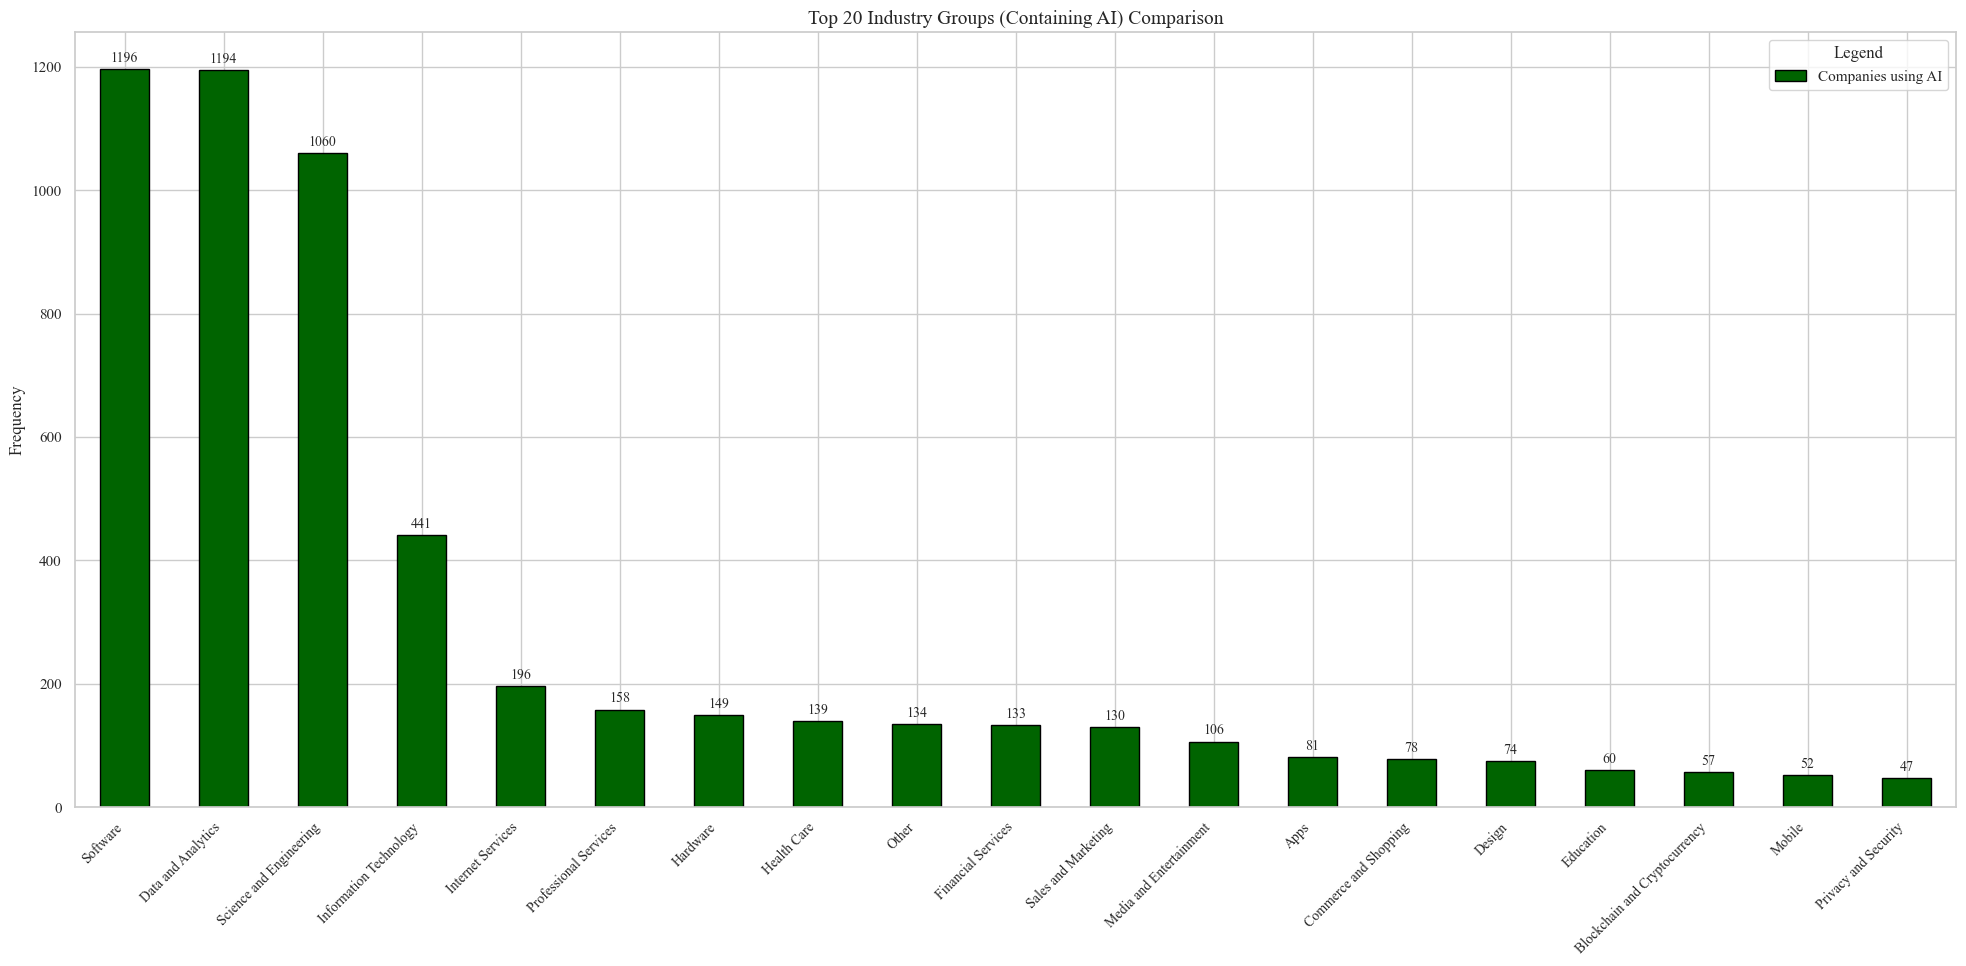

In [569]:
# Filtering rows that contain 'Artificial Intelligence' in 'Industry Groups'
ai_data = scraped_df[scraped_df['Industry Groups'].str.contains('Artificial Intelligence', na=False)]
print(len(ai_data))

# Processing the industry groups for the filtered data
tags_ai = ai_data['Industry Groups'].str.split(',', expand=True).stack().str.strip()
tag_counts_ai = tags_ai.value_counts()

# Creating a dataframe for the AI-related counts
df_ai = tag_counts_ai.rename('Companies using AI').to_frame()

# Removing the 'Artificial Intelligence' industry group from the DataFrame
df_ai = df_ai[df_ai.index != 'Artificial Intelligence']

# Since this code is based on the previous Industry Graph, it needs adjustment of the percentage of companies using AI (all are AI, so it's 100% for each group in the filtered data)
df_ai['Percentage'] = 100.0

# Adding a new column 'Total' for sorting purposes (same as 'Companies using AI')
df_ai['Total'] = df_ai['Companies using AI']

# Sorting by the 'Total' column in descending order
df_ai.sort_values('Total', ascending=False, inplace=True)

# Selecting the top 20 industry groups after sorting
df_ai_top_20 = df_ai.head(20)[['Companies using AI', 'Percentage']]
df_ai_top_20.drop('Artificial Intelligence (AI)', inplace = True, axis = 0)

# Creating the plot
fig, ax = plt.subplots(figsize=(20, 10))
bars = df_ai_top_20[['Companies using AI']].plot(kind='bar', stacked=True, color=['darkgreen'], edgecolor='black', ax=ax)

# Adding the absolute number of values at the top of each bar
for bar in bars.patches:
    height = bar.get_height()
    ax.annotate('{}'.format(int(height)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Setting the labels and 
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Top 20 Industry Groups (Containing AI) Comparison', fontsize=14)
ax.set_xticks(range(len(df_ai_top_20)))
ax.set_xticklabels(df_ai_top_20.index, rotation=45, ha='right', fontsize=10)

plt.legend(title='Legend')
plt.tight_layout()
plt.show()


In [570]:
df_ai_top_20.head()

,Companies using AI,Percentage
Software,1196,100.0
Data and Analytics,1194,100.0
Science and Engineering,1060,100.0
Information Technology,441,100.0
Internet Services,196,100.0


### Most frequent Industry Group in connection with Artificial Intelligence without high correlating Industry Groups

1204


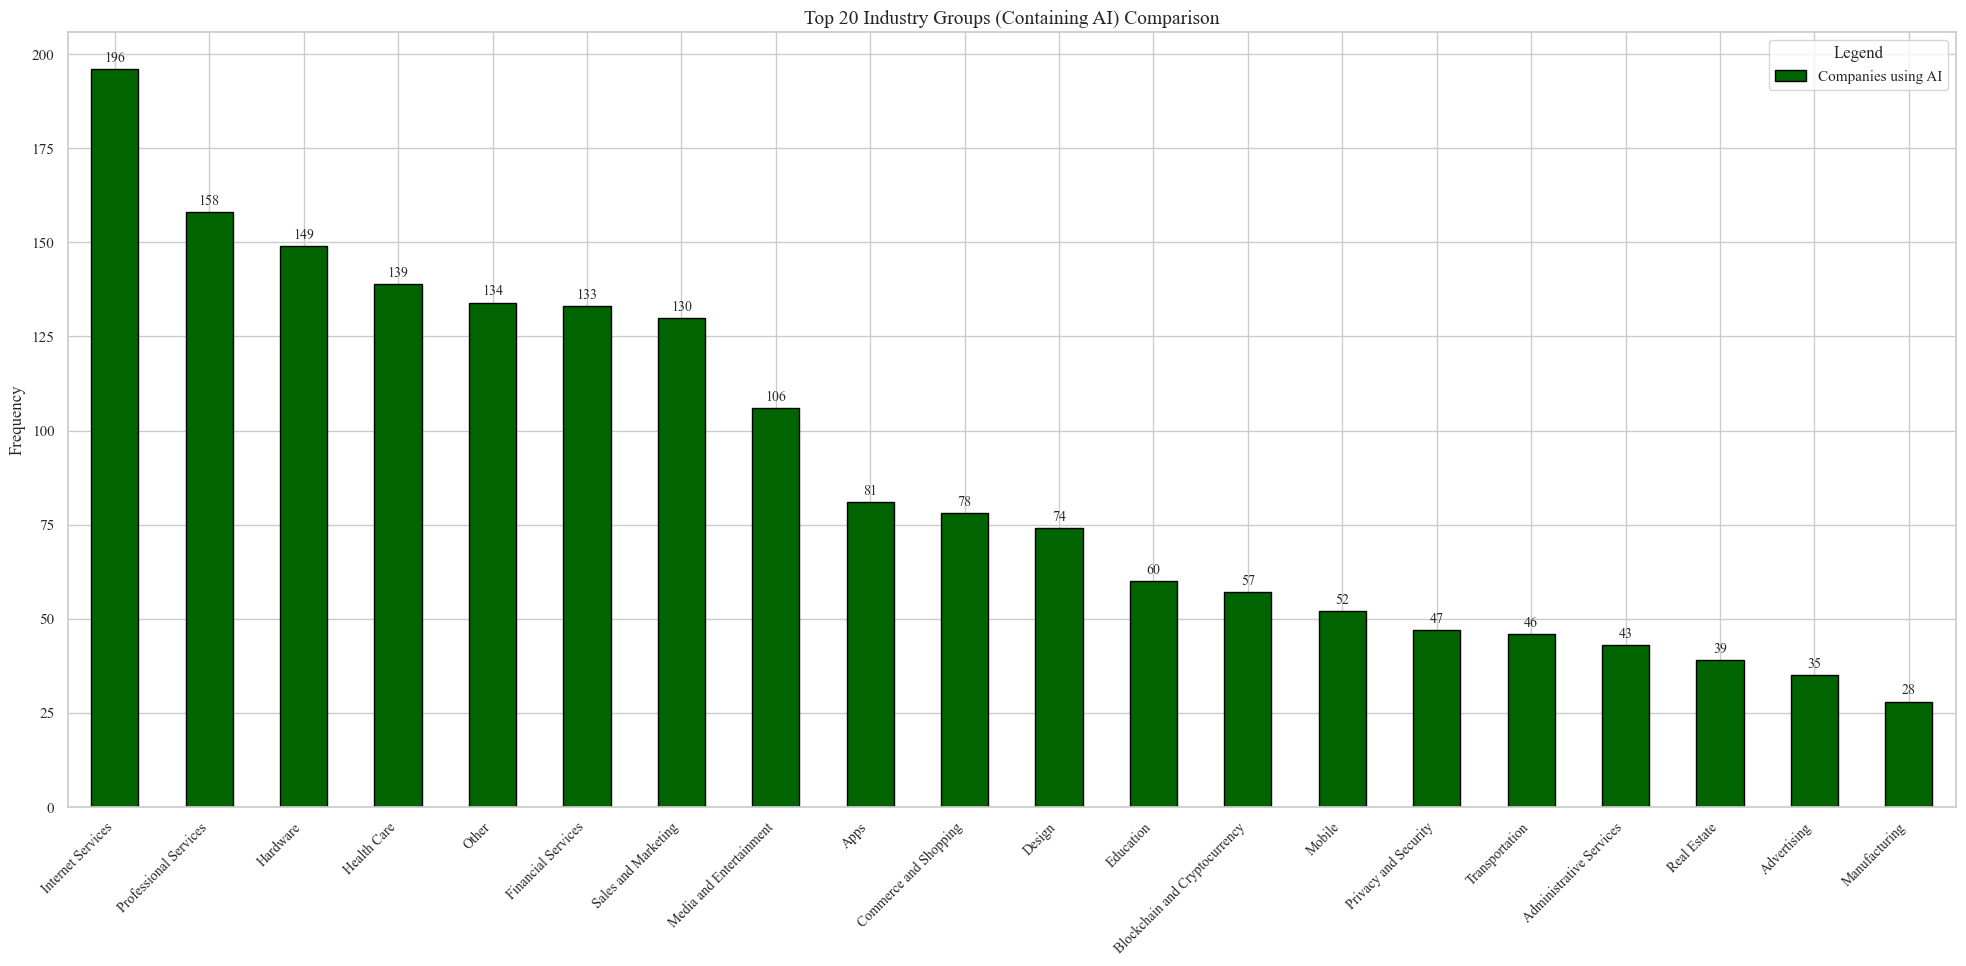

In [571]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming scraped_df is your main dataframe and it's already been defined
# Filter rows that contain 'Artificial Intelligence' in 'Industry Groups'
ai_data = scraped_df[scraped_df['Industry Groups'].str.contains('Artificial Intelligence', na=False)]
print(len(ai_data))

# Process the industry groups for the filtered data
tags_ai = ai_data['Industry Groups'].str.split(',', expand=True).stack().str.strip()
tag_counts_ai = tags_ai.value_counts()

# Create a dataframe for the AI-related counts
df_ai = tag_counts_ai.rename('Companies using AI').to_frame()

# Remove the 'Artificial Intelligence' industry group from the DataFrame
df_ai = df_ai[df_ai.index != 'Artificial Intelligence']

# Exclude specified industry groups
excluded_groups = ["Software", "Data and Analytics", "Information Technology", "Science and Engineering", "Artificial Intelligence (AI)"]
df_ai = df_ai[~df_ai.index.isin(excluded_groups)]

# Since we want to keep the other industry groups that contain AI, we need to re-adjust the percentages
# Calculate the percentage of companies using AI (all are AI, so it's 100% for each group in the filtered data)
df_ai['Percentage'] = 100.0

# Add a new column 'Total' for sorting purposes (same as 'Companies using AI')
df_ai['Total'] = df_ai['Companies using AI']

# Sort by the 'Total' column in descending order
df_ai.sort_values('Total', ascending=False, inplace=True)

# Select the top 20 industry groups after sorting
df_ai_top_20 = df_ai.head(20)[['Companies using AI', 'Percentage']]

fig, ax = plt.subplots(figsize=(20, 10))
bars = df_ai_top_20[['Companies using AI']].plot(kind='bar', stacked=True, color=['darkgreen'], edgecolor='black', ax=ax)

# Annotating the graph
# Adding the absolute number of values at the top of each bar
for bar in bars.patches:
    height = bar.get_height()
    ax.annotate('{}'.format(int(height)),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

# Setting the ax labels and ticks 
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Top 20 Industry Groups (Containing AI) Comparison', fontsize=14)
ax.set_xticks(range(len(df_ai_top_20)))
ax.set_xticklabels(df_ai_top_20.index, rotation=45, ha='right', fontsize=10)

plt.legend(title='Legend')
plt.tight_layout()
plt.show()


In [572]:
# Displaying the most frequent companies using AI 
df_ai_top_20.head()

,Companies using AI,Percentage
Internet Services,196,100.0
Professional Services,158,100.0
Hardware,149,100.0
Health Care,139,100.0
Other,134,100.0


## Heatmap of co-occuring industry groups

In [573]:
from itertools import combinations
from collections import Counter

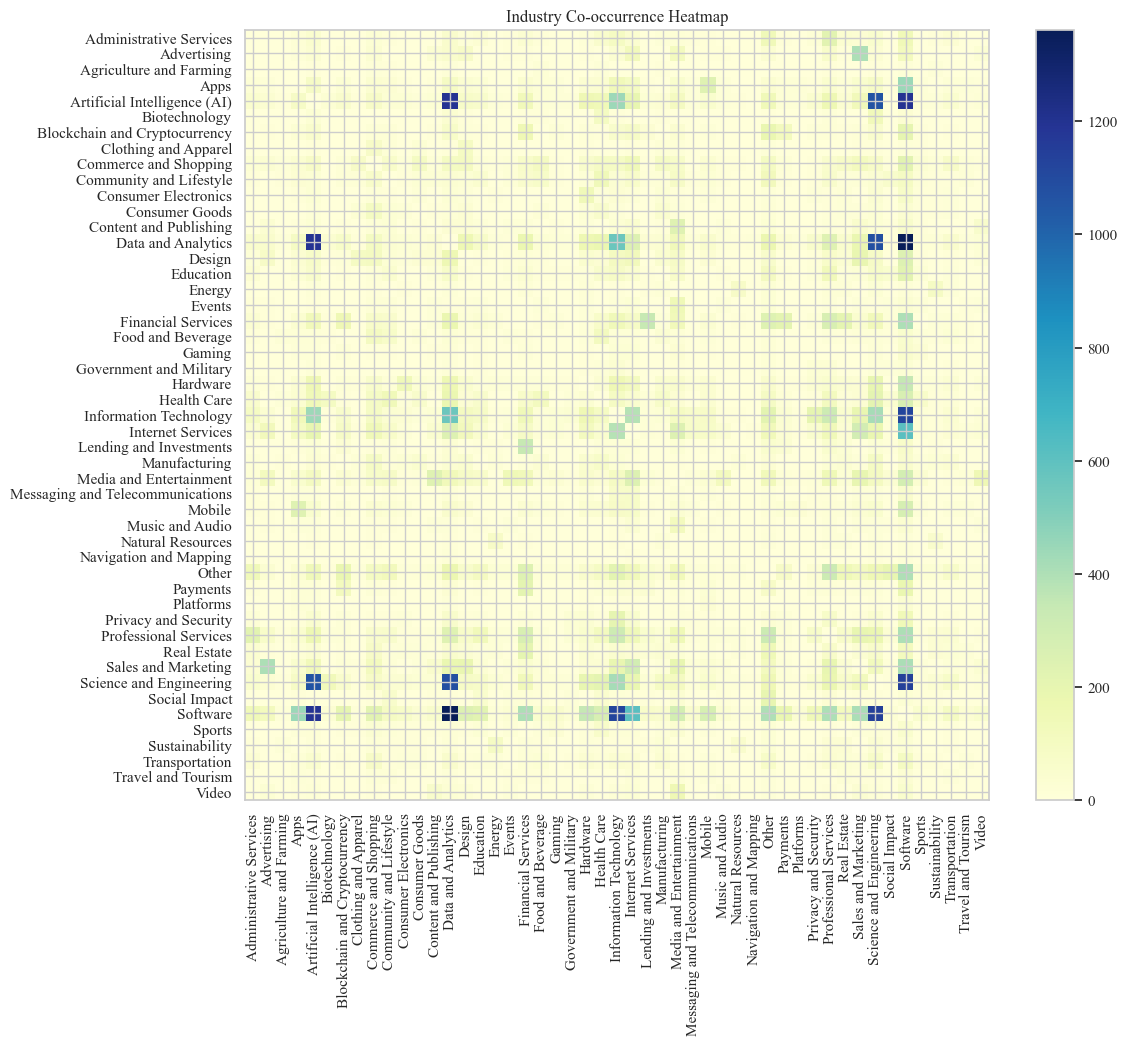

In [574]:
# Splitting the Industry Groups into individual tags
scraped_df['Industry Groups'] = scraped_df['Industry Groups'].str.split(',')

# Filling NaN values with an empty list
scraped_df['Industry Groups'] = scraped_df['Industry Groups'].apply(lambda x: x if isinstance(x, list) else [])

## Generating a covariance map
# Combining all pairs of industries
pair_counts = Counter()
all_industries = set()
for industry_list in scraped_df['Industry Groups']:
    industry_list = [industry.strip() for industry in industry_list if industry.strip()]  # Remove extra spaces and empty strings
    all_industries.update(industry_list)
    for pair in combinations(industry_list, 2):
        pair_counts[frozenset(pair)] += 1

# Converting set to sorted list for consistent ordering
all_industries = sorted(list(all_industries))

# Creating an index mapping for industries
industry_index = {industry: idx for idx, industry in enumerate(all_industries)}

# Initializing the co-occurrence matrix with zeros
matrix_size = len(all_industries)
co_occurrence_matrix = np.zeros((matrix_size, matrix_size), dtype=int)

# Filling the co-occurrence matrix with counts
for key, value in pair_counts.items():
    industry1, industry2 = list(key)
    idx1, idx2 = industry_index[industry1], industry_index[industry2]
    co_occurrence_matrix[idx1, idx2] = value
    co_occurrence_matrix[idx2, idx1] = value  # Ensure symmetry

# Converting the co-occurrence matrix to a DataFrame for easier visualization
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=all_industries, columns=all_industries)

# Plotting the heatmap
plt.figure(figsize=(12, 10))
plt.title('Industry Co-occurrence Heatmap')
plt.imshow(co_occurrence_matrix, cmap='YlGnBu', aspect='auto')
plt.colorbar()
plt.xticks(ticks=range(len(all_industries)), labels=all_industries, rotation=90)
plt.yticks(ticks=range(len(all_industries)), labels=all_industries)
plt.show()

# Comparing Factors of AI Industry with Keyword occurence

Additionally, I also perform some checks on websites that are flagged as part of the industry Group 'Artificial Intelligence', yet no keywords were found.

In [575]:
# Manually check overlap
AI_keyword_overlap_check = scraped_df[(scraped_df['keyword_bin'] == True)& (scraped_df['AI_bin'] == False)]
AI_no_keyword_export = scraped_df[(scraped_df['keyword_bin'] == False)& (scraped_df['AI_bin'] == True)]

AI_keyword_overlap_check_export = AI_keyword_overlap_check.sample(n = 50, random_state = 42)
AI_no_keyword_export = AI_no_keyword_export.sample(n = 50, random_state = 42)

AI_keyword_overlap_check_export.to_excel('Working Docs/AI_keyword_overlap_check.xlsx')
AI_no_keyword_export.to_excel('Working Docs/AI_no_keyword_export.xlsx')

In [576]:
# Looking at companies that are AI companies, but don't have keywords
df_AI_no_keywords = scraped_df[((scraped_df['AI_bin'] == True) & (scraped_df['keyword_bin'] == False))]
print(len(df_AI_no_keywords))

550


In a next step I will look at the data and find influencing factors to better understand the data and its peculiarities. Some discrepancies come from websites that were either incomplete at the point of scraping or resulted in errors due to the Wabyack Machine

In [577]:
df_AI_no_keywords = df_AI_no_keywords[df_AI_no_keywords['text'].str.contains('Wayback') == False]
df_AI_no_keywords = df_AI_no_keywords[df_AI_no_keywords['text'].str.contains('JavaScript') == False]
df_AI_no_keywords = df_AI_no_keywords[df_AI_no_keywords['text'].str.contains('Coming Soon') == False]
print(len(df_AI_no_keywords))

451


In [578]:
df_AI_no_keywords.to_excel('Working Docs/df_AI_no_keywords.xlsx')

In [579]:
# Calculating the average and median text length for AI companies that do not have AI keywords
df_AI_no_keywords = df_AI_no_keywords.copy()
df_AI_no_keywords['text'] = df_AI_no_keywords['text'].astype(str)
df_AI_no_keywords['text_length'] = df_AI_no_keywords['text'].apply(len)
average_text_length_AI_no_keywords = round(df_AI_no_keywords['text_length'].mean(), 1)
median_text_length_AI_no_keywords = round(df_AI_no_keywords['text_length'].median(), 1)

# Calculating the average and median text length for companies that have AI keywords
df_companies_keyword = scraped_df[scraped_df['keyword_bin'] == True].copy()
df_companies_keyword['text'] = df_companies_keyword['text'].astype(str)
df_companies_keyword['text_length'] = df_companies_keyword['text'].apply(len)
average_text_length_keywords = round(df_companies_keyword['text_length'].mean(), 1)
median_text_length_keywords = round(df_companies_keyword['text_length'].median(), 1)

# Calculating the average and median text length for companies that have AI keywords and are in the AI industry
df_AI_keywords = scraped_df[(scraped_df['AI_bin'] == True) & (scraped_df['keyword_bin'] == True)].copy()
df_AI_keywords['text'] = df_AI_keywords['text'].astype(str)
df_AI_keywords['text_length'] = df_AI_keywords['text'].apply(len)
average_text_length_keywords_AI = round(df_AI_keywords['text_length'].mean(), 1)
median_text_length_keywords_AI = round(df_AI_keywords['text_length'].median(), 1)

# Creating a summary DataFrame
summary_data = {
    'Category': [
        'AI companies without AI keywords', 
        'Companies with AI keywords', 
        'AI industry companies with AI keywords'
    ],
    'Average Text Length': [
        average_text_length_AI_no_keywords, 
        average_text_length_keywords, 
        average_text_length_keywords_AI
    ],
    'Median Text Length': [
        median_text_length_AI_no_keywords, 
        median_text_length_keywords, 
        median_text_length_keywords_AI
    ]
}

summary_df = pd.DataFrame(summary_data)

# Displaying the summary table
display(summary_df)

,Category,Average Text Length,Median Text Length
0,AI companies without AI keywords,3176.9,4614.0
1,Companies with AI keywords,4067.2,4999.0
2,AI industry companies with AI keywords,3878.7,4999.0
